### Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. So we need to analyse telecom industry data and predict high value customers who are at high risk of churn and identify main indicators of churn. In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Business objective
The business objective is to predict the churn in the last (i.e. the ninth) month using the features/data from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

### Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### About dataset:
Dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

In [1]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")
# Import Libraries
import sys,joblib
import six
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_context("talk", font_scale = 0.65, rc={"grid.linewidth": 5})
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)
from sklearn.linear_model import LogisticRegression,LinearRegression,LassoCV,Lasso,Ridge,LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.model_selection import GridSearchCV,cross_val_score,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
from sklearn.preprocessing import StandardScaler,MinMaxScaler,QuantileTransformer
from scipy.stats import skew
from fancyimpute import IterativeImputer,KNN
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [2]:
telecom = pd.read_csv('./telecom_churn_data.csv')
telecom.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [3]:
print(telecom.shape)
print('\n')
print(telecom.info(verbose=True, show_counts=True))

(99999, 226)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    mobile_number             99999 non-null  int64  
 1    circle_id                 99999 non-null  int64  
 2    loc_og_t2o_mou            98981 non-null  float64
 3    std_og_t2o_mou            98981 non-null  float64
 4    loc_ic_t2o_mou            98981 non-null  float64
 5    last_date_of_month_6      99999 non-null  object 
 6    last_date_of_month_7      99398 non-null  object 
 7    last_date_of_month_8      98899 non-null  object 
 8    last_date_of_month_9      98340 non-null  object 
 9    arpu_6                    99999 non-null  float64
 10   arpu_7                    99999 non-null  float64
 11   arpu_8                    99999 non-null  float64
 12   arpu_9                    99999 non-null  float64
 13   onnet_mou_6               960

In [4]:
# Summary and checking outliers
telecom.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean     132.395875    133.670805    133.018098    130.302327    197.935577   
std      297.207406    308.794148    308.951589    308.477668    316.851613   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.380000      6.660000      6.460000      5.330000     34.730000   
50%       34.310000     32.330000     32.360000     29.840000     96.310000   
75%      118.740000    115.595000    115.860000    112.130000    231.860000   
max     7376.710000   8157.780000  10752.560000  10427.460000   8362.360000   

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000   96062.000000   96140.000000   
mean     197.045133    196.574803    190.337222       9.950013       7.149898   
std      325.862803    327.170662    319.396092      72.825411      73.447948   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       32.190000     31.630000     27.130000       0.000000       0.000000   
50%       91.735000     92.140000     87.290000       0.000000       0.000000   
75%      226.815000    228.260000    220.505000       0.000000       0.000000   
max     9667.130000  14007.340000  10310.760000   13724.380000   15371.040000   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count   94621.000000   92254.000000   96062.000000   96140.000000   
mean        7.292981       6.343841      13.911337       9.818732   
std        68.402466      57.137537      71.443196      58.455762   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max     13095.360000    8464.030000    3775.110000    2812.040000   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   94621.000000   92254.000000      96062.000000      96140.000000   
mean        9.971890       8.555519         47.100763         46.473010   
std        64.713221      58.438186        150.856393        155.318705   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.630000   
50%         0.000000       0.000000         11.910000         11.610000   
75%         0.000000       0.000000         40.960000         39.910000   
max      

In [5]:
# Function to check percentage f null values present in dataset
def calnullpercentage(df):
    missing_num = df[df.columns].isna().sum().sort_values(ascending=False)
    missing_perc = (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending=False)
    missing = pd.concat([missing_num, missing_perc], keys=['Total', 'Percentage'], axis=1)
    missing = missing[missing['Percentage'] > 0]
    # missing['Total'] = missing['Total'].apply(lambda x: f'{x:,}')
    # missing['Percentage'] = missing['Percentage'].apply(lambda x: f'{x:.2f}%')
    return missing

In [6]:
calnullpercentage(telecom)

Total  Percentage
arpu_3g_6                 74846   74.846748
night_pck_user_6          74846   74.846748
total_rech_data_6         74846   74.846748
arpu_2g_6                 74846   74.846748
max_rech_data_6           74846   74.846748
fb_user_6                 74846   74.846748
av_rech_amt_data_6        74846   74.846748
date_of_last_rech_data_6  74846   74.846748
count_rech_2g_6           74846   74.846748
count_rech_3g_6           74846   74.846748
date_of_last_rech_data_7  74428   74.428744
total_rech_data_7         74428   74.428744
fb_user_7                 74428   74.428744
max_rech_data_7           74428   74.428744
night_pck_user_7          74428   74.428744
count_rech_2g_7           74428   74.428744
av_rech_amt_data_7        74428   74.428744
arpu_2g_7                 74428   74.428744
count_rech_3g_7           74428   74.428744
arpu_3g_7                 74428   74.428744
total_rech_data_9         74077   74.077741
count_rech_3g_9           74077   74.077741
fb_user_9                 74077   74.077741
max_rech_data_9           74077   74.077741
arpu_3g_9                 74077   74.077741
date_of_last_rech_data_9  74077   74.077741
night_pck_user_9          74077   74.077741
arpu_2g_9                 74077   74.077741
count_rech_2g_9           74077   74.077741
av_rech_amt_data_9        74077   74.077741
total_rech_data_8         73660   73.660737
arpu_3g_8                 73660   73.660737
fb_user_8                 73660   73.660737
night_pck_user_8          73660   73.660737
av_rech_amt_data_8        73660   73.660737
max_rech_data_8           73660   73.660737
count_rech_3g_8           73660   73.660737
arpu_2g_8                 73660   73.660737
count_rech_2g_8           73660   73.660737
date_of_last_rech_data_8  73660   73.660737
ic_others_9                7745    7.745077
std_og_mou_9               7745    7.745077
std_og_t2c_mou_9           7745    7.745077
isd_ic_mou_9               7745    7.745077
std_ic_mou_9               7745    7.745077
isd_og_mou_9               7745    7.745077
spl_og_mou_9               7745    7.745077
spl_ic_mou_9               7745    7.745077
og_others_9                7745    7.745077
loc_ic_t2t_mou_9           7745    7.745077
std_ic_t2o_mou_9           7745    7.745077
loc_ic_t2m_mou_9           7745    7.745077
std_ic_t2f_mou_9           7745    7.745077
loc_ic_t2f_mou_9           7745    7.745077
loc_ic_mou_9               7745    7.745077
std_ic_t2m_mou_9           7745    7.745077
std_og_t2f_mou_9           7745    7.745077
std_og_t2t_mou_9           7745    7.745077
std_ic_t2t_mou_9           7745    7.745077
loc_og_mou_9               7745    7.745077
roam_og_mou_9              7745    7.745077
loc_og_t2m_mou_9           7745    7.745077
loc_og_t2f_mou_9           7745    7.745077
roam_ic_mou_9              7745    7.745077
offnet_mou_9               7745    7.745077
loc_og_t2c_mou_9           7745    7.745077
loc_og_t2t_mou_9           7745    7.745077
std_og_t2m_mou_9           7745    7.745077
onnet_mou_9                7745    7.745077
onnet_mou_8                5378    5.378054
std_ic_t2t_mou_8           5378    5.378054
std_ic_mou_8               5378    5.378054
loc_ic_t2t_mou_8           5378    5.378054
roam_og_mou_8              5378    5.378054
std_ic_t2m_mou_8           5378    5.378054
loc_ic_mou_8               5378    5.378054
std_ic_t2f_mou_8           5378    5.378054
roam_ic_mou_8              5378    5.378054
std_ic_t2o_mou_8           5378    5.378054
loc_og_t2t_mou_8           5378    5.378054
loc_ic_t2f_mou_8           5378    5.378054
offnet_mou_8               5378    5.378054
loc_ic_t2m_mou_8           5378    5.378054
loc_og_t2m_mou_8           5378    5.378054
isd_og_mou_8               5378    5.378054
ic_others_8                5378    5.378054
og_others_8                5378    5.378054
spl_ic_mou_8               5378    5.378054
loc_og_t2f_mou_8           5378    5.378054
std_og_t2m_mou_8           5378    5.378054
spl_og_mou_8          

In [7]:
len(calnullpercentage(telecom))

166

Out of 226 Columns, 166 have null values

In [8]:
telecom.select_dtypes(include='object').head(3)

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9 date_of_last_rech_6 date_of_last_rech_7  \
0            9/30/2014           6/21/2014           7/16/2014   
1            9/30/2014           6/29/2014           7/31/2014   
2            9/30/2014           6/17/2014           7/24/2014   

  date_of_last_rech_8 date_of_last_rech_9 date_of_last_rech_data_6  \
0            8/8/2014           9/28/2014                6/21/2014   
1           8/28/2014           9/30/2014                      NaN   
2           8/14/2014           9/29/2014                      NaN   

  date_of_last_rech_data_7 date_of_last_rech_data_8 date_of_last_rech_data_9  
0                7/16/2014                 8/8/2014                      NaN  
1                7/25/2014                8/10/2014                      NaN  
2                      NaN                      NaN                9/17/2014

##### Filter High-Value Customers
We need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [9]:
# Deriving new columns for total recharge amount data for 6 and 7th month
telecom['tot_rech_amt_data_6'] = telecom['total_rech_data_6'] * telecom['av_rech_amt_data_6']
telecom['tot_rech_amt_data_7'] = telecom['total_rech_data_7'] * telecom['av_rech_amt_data_7']

# Deriving new columns for total amount spent during 6 and 7th month
telecom['tot_amt_6'] = telecom[['total_rech_amt_6', 'tot_rech_amt_data_6']].sum(axis=1)
telecom['tot_amt_7'] = telecom[['total_rech_amt_7', 'tot_rech_amt_data_7']].sum(axis=1)

# First two months average
telecom['avg_amt_6_7'] = telecom[['tot_amt_6', 'tot_amt_7']].mean(axis=1)

# Filtering customers based on percentile havoong goodphase_avg more than or equal to cutoff of 70th percentile
telecom = telecom.loc[(telecom['avg_amt_6_7'] >= np.percentile(telecom['avg_amt_6_7'], 70))]

telecom.shape

(30001, 231)

I have taken  recharge amountmore than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months and getting 30k rows. If I usemore than(>)sign, will get 29.9k rows, but going with problem statement.

In [10]:
# Deriving new columns for total recharge amount data for 8 and 9th month
telecom['tot_rech_amt_data_8'] = telecom['total_rech_data_8'] * telecom['av_rech_amt_data_8']
telecom['tot_rech_amt_data_9'] = telecom['total_rech_data_9'] * telecom['av_rech_amt_data_9']

# Deriving new columns for total amount spent during 8 and 9th month
telecom['tot_amt_8'] = telecom[['total_rech_amt_8', 'tot_rech_amt_data_8']].sum(axis=1)
telecom['tot_amt_9'] = telecom[['total_rech_amt_9', 'tot_rech_amt_data_9']].sum(axis=1)

In [11]:
# Finding categorical columns where dtype is float but those columns are having 0 or 1 values only
cats = []
for col in telecom.columns:
    if len(telecom[col].unique()) == 2 | 3:
        cats.append(col)

# Converting into categorical or object type
telecom[cats] = telecom[cats].apply(lambda x: x.astype('object'))
"""
accessing column using np.r_
`total_rech_num_6` to `total rech_num_9`
`total_rech_data_6` to `total_rech_data_9`
"""
col_tmp = telecom.columns[np.r_[137:141, 161:165]]
telecom[col_tmp] = telecom[col_tmp].apply(lambda x: x.astype('object'))

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'tot_amt_8'),
  Text(1.5, 0, 'total_rech_amt_8'),
  Text(2.5, 0, 'tot_rech_amt_data_8'),
  Text(3.5, 0, 'total_rech_data_8'),
  Text(4.5, 0, 'av_rech_amt_data_8')])

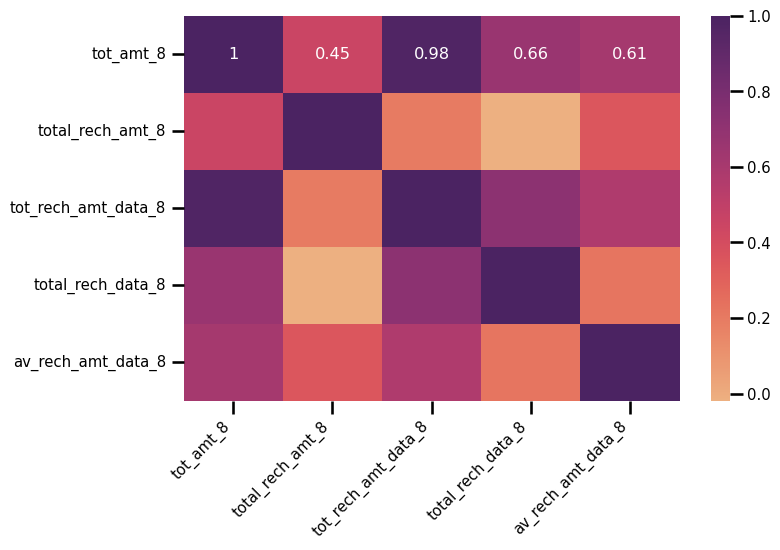

In [12]:
x = ['tot_amt_8', 'total_rech_amt_8', 'tot_rech_amt_data_8', 'total_rech_data_8', 'av_rech_amt_data_8']
plt.figure(figsize=(8,5))
fig = sns.heatmap(telecom[x].corr(), annot=True, cmap='flare')
plt.xticks(rotation=45, horizontalalignment='right')
# fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

Dropping Redundant columns, since we have already created derived features from them and derived features reflects the same information.

In [13]:
telecom.drop(['tot_rech_amt_data_6', 'tot_rech_amt_data_7','tot_rech_amt_data_8', 'tot_rech_amt_data_9'], inplace=True, axis=1)

### Identifying CHURN CUSTOMERS
Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

* total_ic_mou_9
* total_og_mou_9
* vol_2g_mb_9
* vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [14]:
# Where summation of columns = 0 then churn = 1 else 0
telecom['churn'] = np.where(telecom[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis=1) == 0,1,0)

In [15]:
# Removing all features having '_9', etc. in their names
telecom.drop(telecom.filter(regex='_9|sep', axis=1).columns, axis=1, inplace=True)

In [16]:
pd.DataFrame(round(telecom['churn'].value_counts(normalize=True)*100,2))

proportion
churn            
0           91.86
1            8.14

Approximately 92% customers not churned and 8% customers got churned. Also, we can see class imbalance is there and we will deal with it later

For each feature, it counts the values of that feature. If the most recurrent value of the feature is repeated almost in all the instances (**zeros / len(X) * 100 > 95**). Then it drops these features because their values are almost the same for all instances and will not help in learning process and those features are not useful in our prediction.

In [17]:
telecom.shape

(30001, 176)

In [18]:
def redundant_features(df):
    redundant = []
    for i in df.columns:
        counts = df[i].value_counts()
        count_max = counts.iloc[0]
        if count_max / len(df) * 100 > 95:
            redundant.append(i)
    redundant = list(redundant)
    return redundant

In [19]:
print('Before dropping Redundant features: ', telecom.shape)
redundant_features = redundant_features(telecom)
telecom = telecom.drop(redundant_features, axis=1)
print('After dropping Redundant features: ', telecom.shape)

Before dropping Redundant features:  (30001, 176)
After dropping Redundant features:  (30001, 161)


Function to impute NaN values where %age of missing values > 40%, Reason for taking cutoff 40% is beacuse for these columns we can replace NaN with 0(for example, fb_user_7, not used facebook(NaN),av_rech_amt_data_8, not done recharge(NaN) similarly for other columns.

In [20]:
""" 
# Function to impute NaN with 0
Function to impute NaN values where %age of missing values > 40%,
Reason for taking cutoff 40% is beacuse for these columns we can replace NaN with 0
(for example, fb_user_7, not used facebook(NaN),av_rech_amt_data_8, not done recharge(NaN) similarly for other columns.
"""

def imputeNaN(df, col_name):
    for col in col_name:
        df[col].fillna(0, inplace=True)

col_40 = calnullpercentage(telecom)[calnullpercentage(telecom)['Percentage'] > 40].index

# Call Function
imputeNaN(telecom, col_40)

In [21]:
calnullpercentage(telecom)

Total  Percentage
loc_ic_t2f_mou_8      1174    3.913203
std_ic_t2t_mou_8      1174    3.913203
std_ic_t2f_mou_8      1174    3.913203
std_og_t2t_mou_8      1174    3.913203
std_og_mou_8          1174    3.913203
loc_og_mou_8          1174    3.913203
std_ic_t2m_mou_8      1174    3.913203
loc_og_t2c_mou_8      1174    3.913203
std_ic_mou_8          1174    3.913203
isd_og_mou_8          1174    3.913203
loc_og_t2f_mou_8      1174    3.913203
spl_og_mou_8          1174    3.913203
loc_og_t2m_mou_8      1174    3.913203
spl_ic_mou_8          1174    3.913203
std_og_t2f_mou_8      1174    3.913203
loc_og_t2t_mou_8      1174    3.913203
roam_og_mou_8         1174    3.913203
loc_ic_t2t_mou_8      1174    3.913203
ic_others_8           1174    3.913203
loc_ic_t2m_mou_8      1174    3.913203
onnet_mou_8           1174    3.913203
loc_ic_mou_8          1174    3.913203
offnet_mou_8          1174    3.913203
std_og_t2m_mou_8      1174    3.913203
isd_ic_mou_8          1174    3.913203
roam_ic_mou_8         1174    3.913203
date_of_last_rech_8    583    1.943269
spl_og_mou_6           545    1.816606
std_ic_t2m_mou_6       545    1.816606
std_ic_t2t_mou_6       545    1.816606
isd_og_mou_6           545    1.816606
og_others_6            545    1.816606
loc_ic_t2f_mou_6       545    1.816606
std_ic_t2f_mou_6       545    1.816606
loc_ic_t2t_mou_6       545    1.816606
std_og_mou_6           545    1.816606
loc_ic_t2m_mou_6       545    1.816606
spl_ic_mou_6           545    1.816606
isd_ic_mou_6           545    1.816606
loc_og_t2f_mou_6       545    1.816606
onnet_mou_6            545    1.816606
offnet_mou_6           545    1.816606
ic_others_6            545    1.816606
roam_ic_mou_6          545    1.816606
roam_og_mou_6          545    1.816606
loc_og_t2t_mou_6       545    1.816606
std_og_t2f_mou_6       545    1.816606
loc_og_t2m_mou_6       545    1.816606
std_og_t2t_mou_6       545    1.816606
loc_og_t2c_mou_6       545    1.816606
loc_og_mou_6           545    1.816606
loc_ic_mou_6           545    1.816606
std_ic_mou_6           545    1.816606
std_og_t2m_mou_6       545    1.816606
std_ic_t2m_mou_7       537    1.789940
spl_ic_mou_7           537    1.789940
std_ic_t2t_mou_7       537    1.789940
isd_ic_mou_7           537    1.789940
std_ic_mou_7           537    1.789940
ic_others_7            537    1.789940
loc_ic_mou_7           537    1.789940
std_ic_t2f_mou_7       537    1.789940
loc_ic_t2f_mou_7       537    1.789940
loc_og_t2m_mou_7       537    1.789940
std_og_t2t_mou_7       537    1.789940
onnet_mou_7            537    1.789940
offnet_mou_7           537    1.789940
roam_ic_mou_7          537    1.789940
roam_og_mou_7          537    1.789940
loc_og_t2t_mou_7       537    1.789940
loc_ic_t2m_mou_7       537    1.789940
loc_og_t2f_mou_7       537    1.789940
loc_og_mou_7           537    1.789940
loc_og_t2c_mou_7       537    1.789940
std_og_t2m_mou_7       537    1.789940
std_og_t2f_mou_7       537    1.789940
std_og_mou_7           537    1.789940
isd_og_mou_7           537    1.789940
spl_og_mou_7           537    1.789940
loc_ic_t2t_mou_7       537    1.789940
date_of_last_rech_7     98    0.326656
date_of_last_rech_6     73    0.243325

As we can see from above missing value dataframe and value count == 0, large percentage of values are zero in missing value columns. I can impute most missing value column having NaN value with 0 if I assume that they have not use local incoming service, special outgoing service that is why these columns have NaN values. But this assumption doesn't helping much beacuse most values in these columns have 0 and it infers the same thing. So Imputing missing values for columns mentioned above.

In [22]:
pd.DataFrame((telecom[calnullpercentage(telecom).index] == 0).sum().head())

0
loc_ic_t2f_mou_8   9189
std_ic_t2t_mou_8  13354
std_ic_t2f_mou_8  21248
std_og_t2t_mou_8  13297
std_og_mou_8       7468

In [23]:
imput_col = list(set(calnullpercentage(telecom).index) - set(('date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8')))
knn_imp = KNNImputer()
telecom[imput_col] = knn_imp.fit_transform(telecom[imput_col])
calnullpercentage(telecom)

Total  Percentage
date_of_last_rech_8    583    1.943269
date_of_last_rech_7     98    0.326656
date_of_last_rech_6     73    0.243325

In [24]:
telecom.fillna(0, inplace=True)
# Checking % of null values
calnullpercentage(telecom)

Empty DataFrame
Columns: [Total, Percentage]
Index: []

In [25]:
telecom.shape

(30001, 161)

In [26]:
# Checking missing value percentage if any
calnullpercentage(telecom)

Empty DataFrame
Columns: [Total, Percentage]
Index: []

In [27]:
telecom.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
0      7000842753   197.385   214.816   213.803        0.402         0.00   
7      7000701601  1069.180  1349.850  3171.480       57.840        54.68   
8      7001524846   378.721   492.223   137.362      413.690       351.03   
21     7002124215   514.453   597.753   637.760      102.410       132.11   
23     7000887461    74.350   193.897   366.966       48.960        50.66   

    onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
0          0.00         2.176          2.21          0.00           0.00   
7         52.29       453.430        567.16        325.91          16.23   
8         35.08        94.660         80.63        136.48           0.00   
21        85.14       757.930        896.68        983.39           0.00   
23        33.58        85.410         89.36        205.89           0.00   

    roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.00           0.00           0.00           0.00           0.00   
7           33.49          31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              0.402              0.00              0.00             1.098   
7             51.390             31.38             40.28           308.630   
8            297.130            217.59             12.49            80.960   
21             4.480              6.16             23.34            91.810   
23            48.960             50.66             33.58            82.940   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0              0.106              0.00              0.00              0.07   
7            447.380            162.28             62.13             55.14   
8             70.580             50.54              0.00              0.00   
21            87.930            104.81              0.75              0.00   
23            83.010            148.56              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0               0.00             1.078             0.566              0.00   
7              53.23             0.000             0.000              0.00   
8               0.00             0.000             0.000              7.15   
21              1.58             0.000             0.000              0.00   
23              0.00             0.000             0.000             17.71   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0           1.50         0.176          0.00              0.00   
7         422.16       533.910        255.79              4.30   
8         378.09       288.180         63.04            116.56   
21         97.04        94.090        129.74             97.93   
23        131.91       133.680        182.14              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0               0.00              0.00              0.00              0.00   
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.00              0.00              0.00              0.00   
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21          

In [28]:
# No Duplicate mobile number
len(telecom['mobile_number'].unique())

30001

In [29]:

telecom.drop('mobile_number', inplace=True, axis=1)


### **Data Visualisation and EDA**

In [30]:
def showvalues(ax, m=None):
    for p in ax.patches:
        ax.annotate(
            '%.1f' % p.get_height(),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=14, color='k', rotation=0, xytext=(0,7),
            textcoords='offset points', fontweight='light', alpha=.9)

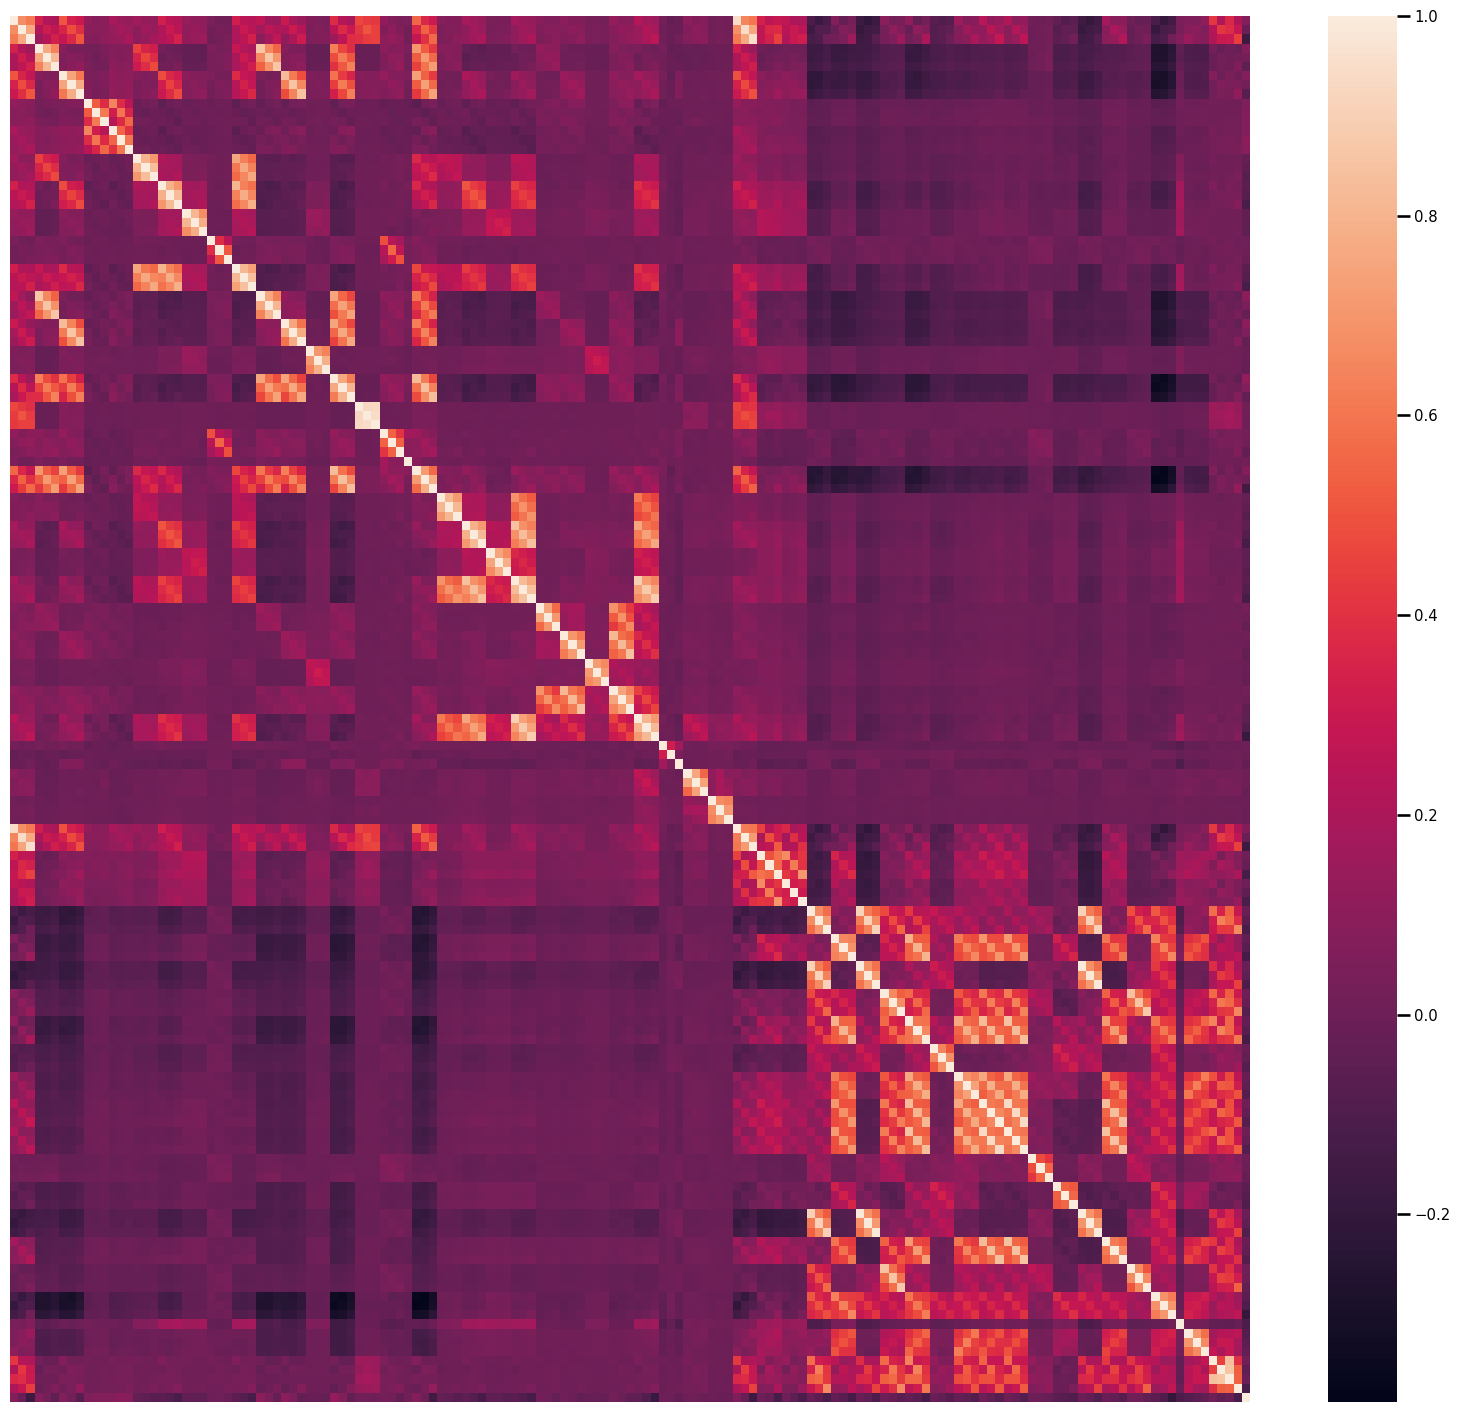

In [31]:
# Corr between numerical variables
plt.figure(figsize=(20,18))
ax = sns.heatmap(telecom.corr(numeric_only=True))
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(
    top=False, bottom=False, left=False, right=False,
    labelleft=False, labelbottom=False
)

In [32]:
# Function to plot distribution plot for months (6,7 and 8) for churn and non churn customers
# Also plotting boxplot and strip plot for the same

def plot_distribution(ax, data, column, title, color):
    sns.histplot(data[column], bins=40, ax=ax, kde=False, color=color, kde_kws={'alpha': 1})
    ax.set_title(title, fontweight='bold', size=20)

def plot_box_strip(ax, data, column):
    sns.boxplot(x='churn', y=column, data=data, ax=ax, orient='v')
    sns.stripplot(x='churn', y=column, data=data, jitter=True, edgecolor='gray', ax=ax, hue='churn', orient='v')
    ax.yaxis.label.set_visible(False)
    ax.set_title(column, fontweight='bold', size=20)

def dist_box_plot(df, col1, col2, col3):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(40, 7))
    
    plot_distribution(axes[0], df[df['churn'] == 1], col1, 'Churn', '#ED1C24')
    plot_distribution(axes[1], df[df['churn'] == 0], col1, 'Non-Churn', '#C0C0C0')
    plot_distribution(axes[2], df[df['churn'] == 1], col2, 'Churn', '#ED1C24')
    plot_distribution(axes[3], df[df['churn'] == 0], col2, 'Non-Churn', '#C0C0C0')
    plot_distribution(axes[4], df[df['churn'] == 1], col3, 'Churn', '#ED1C24')
    plot_distribution(axes[5], df[df['churn'] == 0], col3, 'Non-Churn', '#C0C0C0')
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    plot_box_strip(axes[0], df, col1)
    plot_box_strip(axes[1], df, col2)
    plot_box_strip(axes[2], df, col3)    

In [33]:
inc_cols = telecom.columns[np.r_[:12, 15:21, 30:33, 42:45, 45:48, 52:55, 58:61, 76:79, 91:94, 94:97, 100:103, 109:112, 118:121, 121:127, 127:133, 152:155, 155:157, 158, 106:109]]
inc_cols

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'av_rech_amt_data_6', 'av_rech_amt

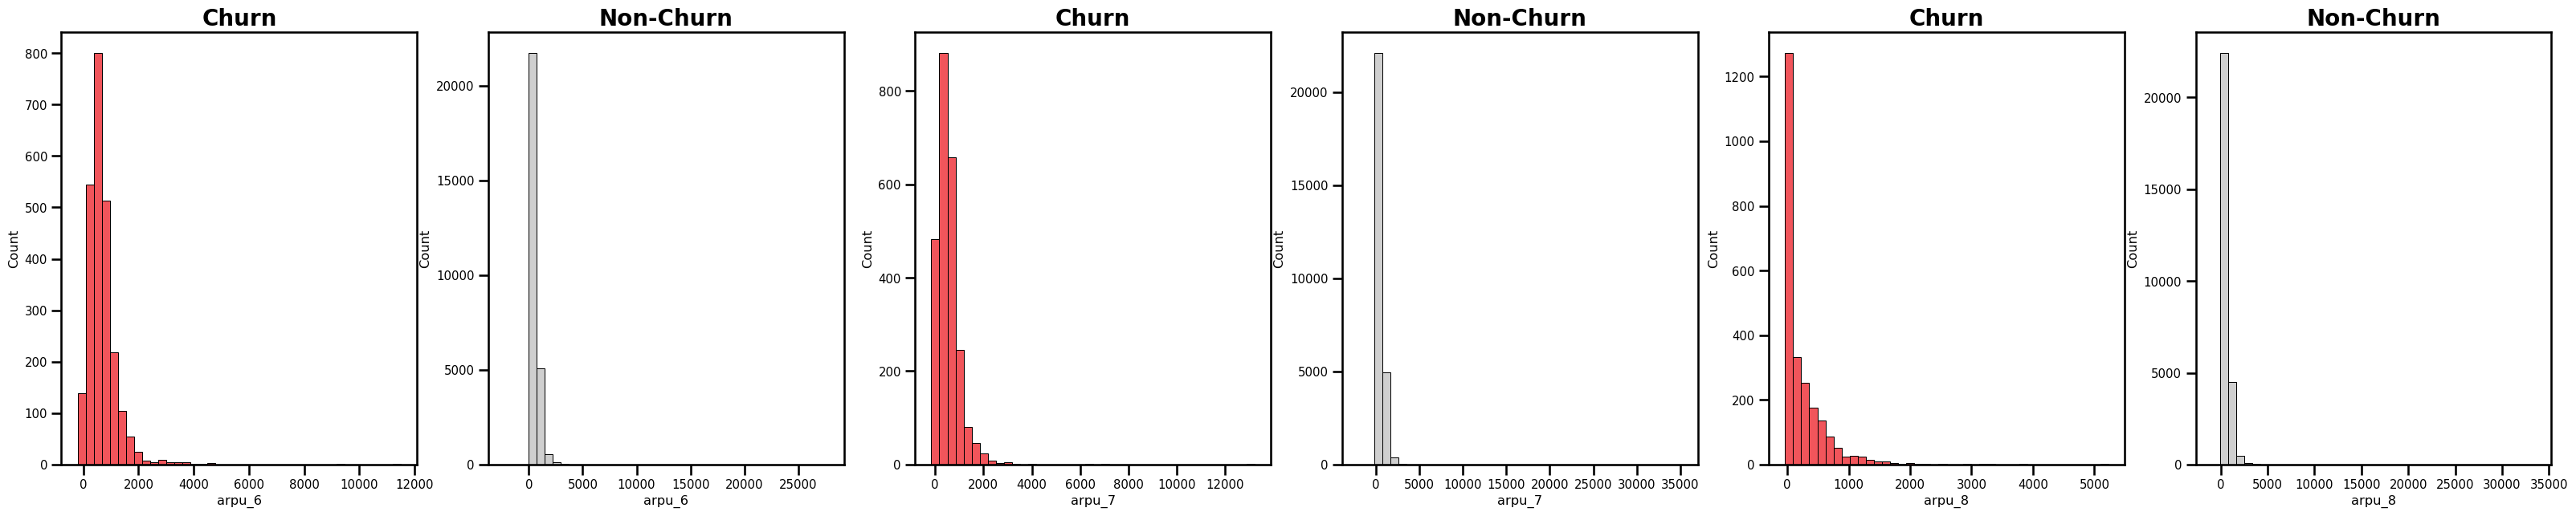

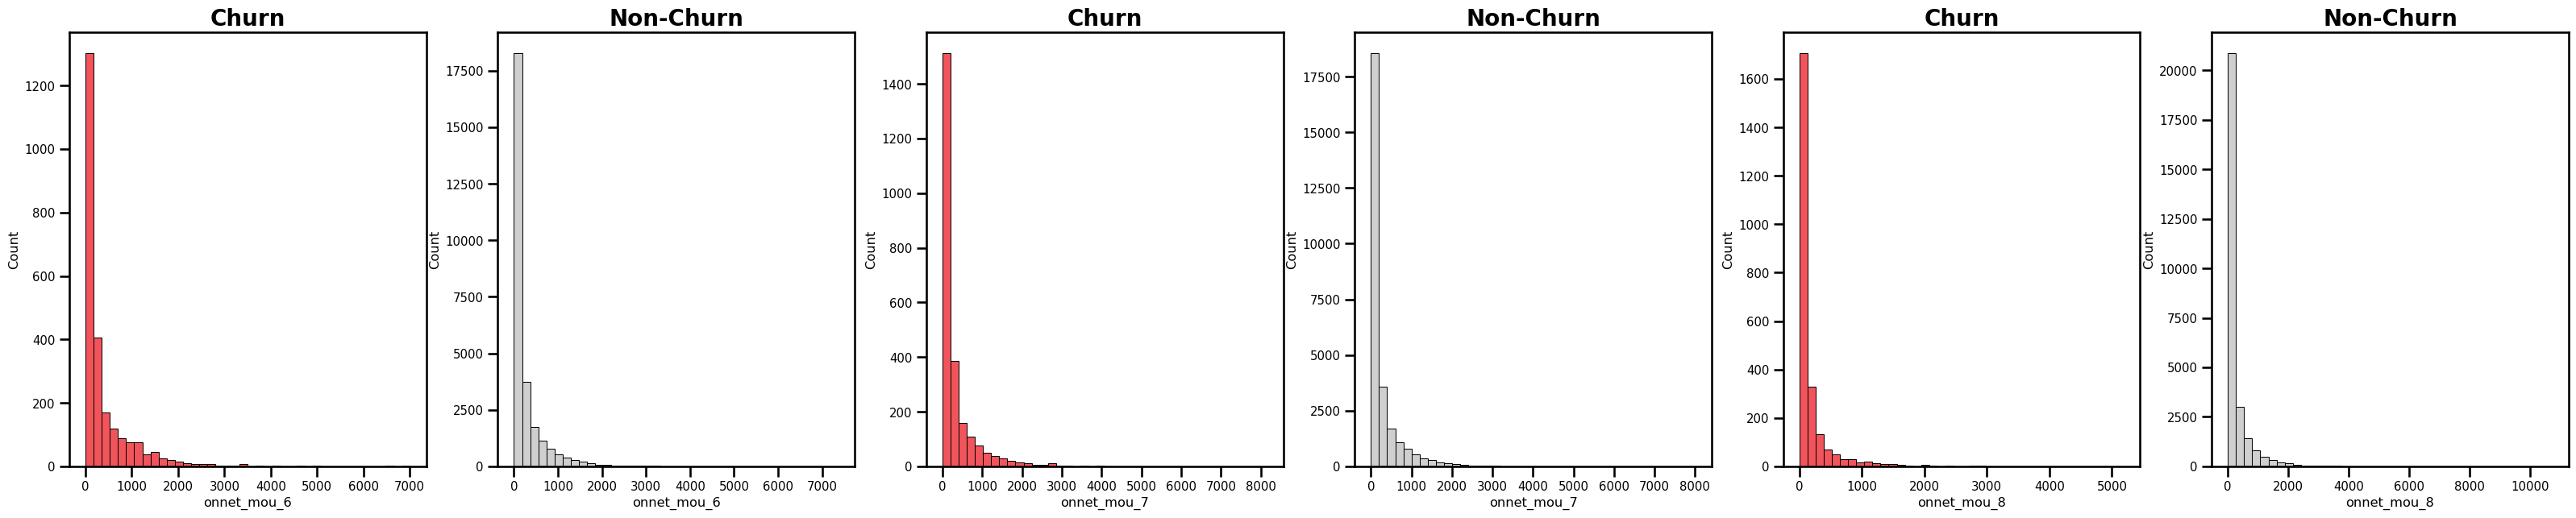

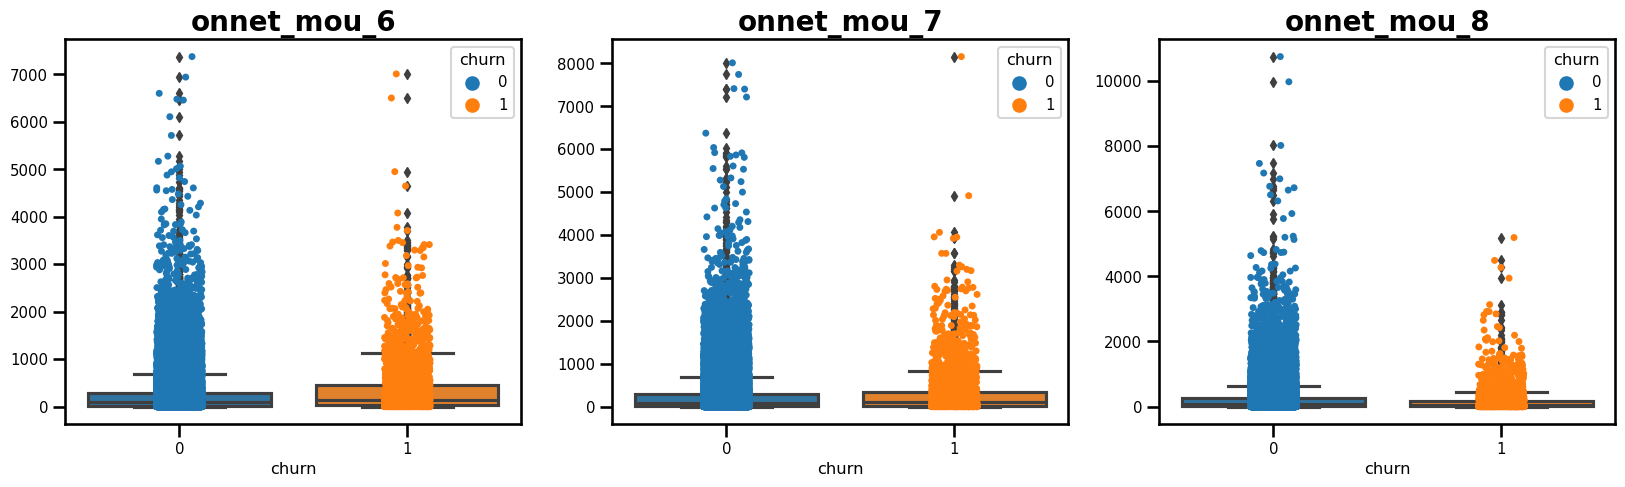

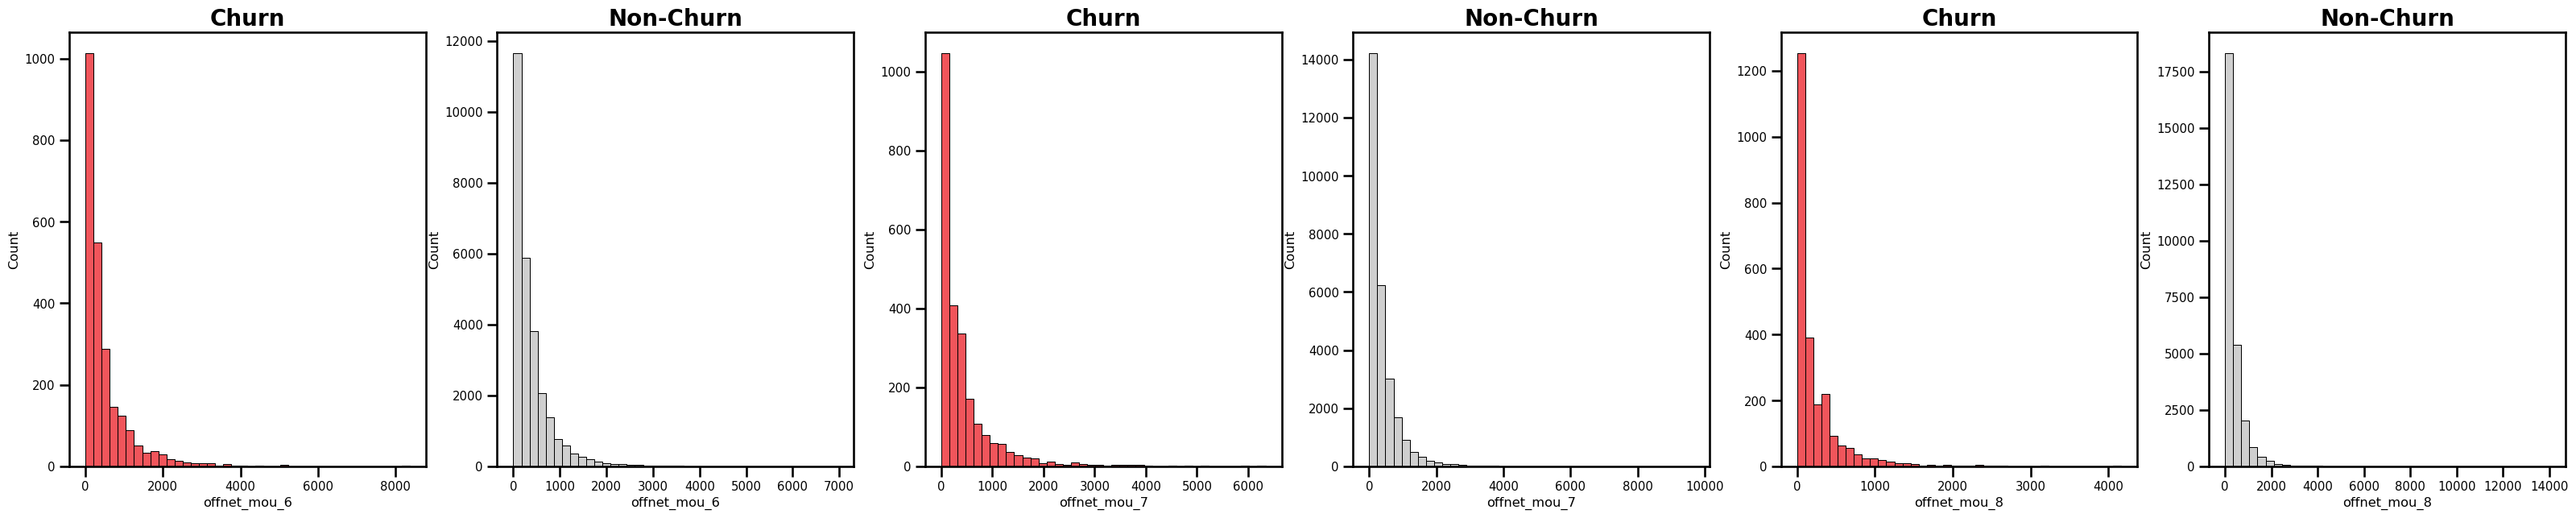

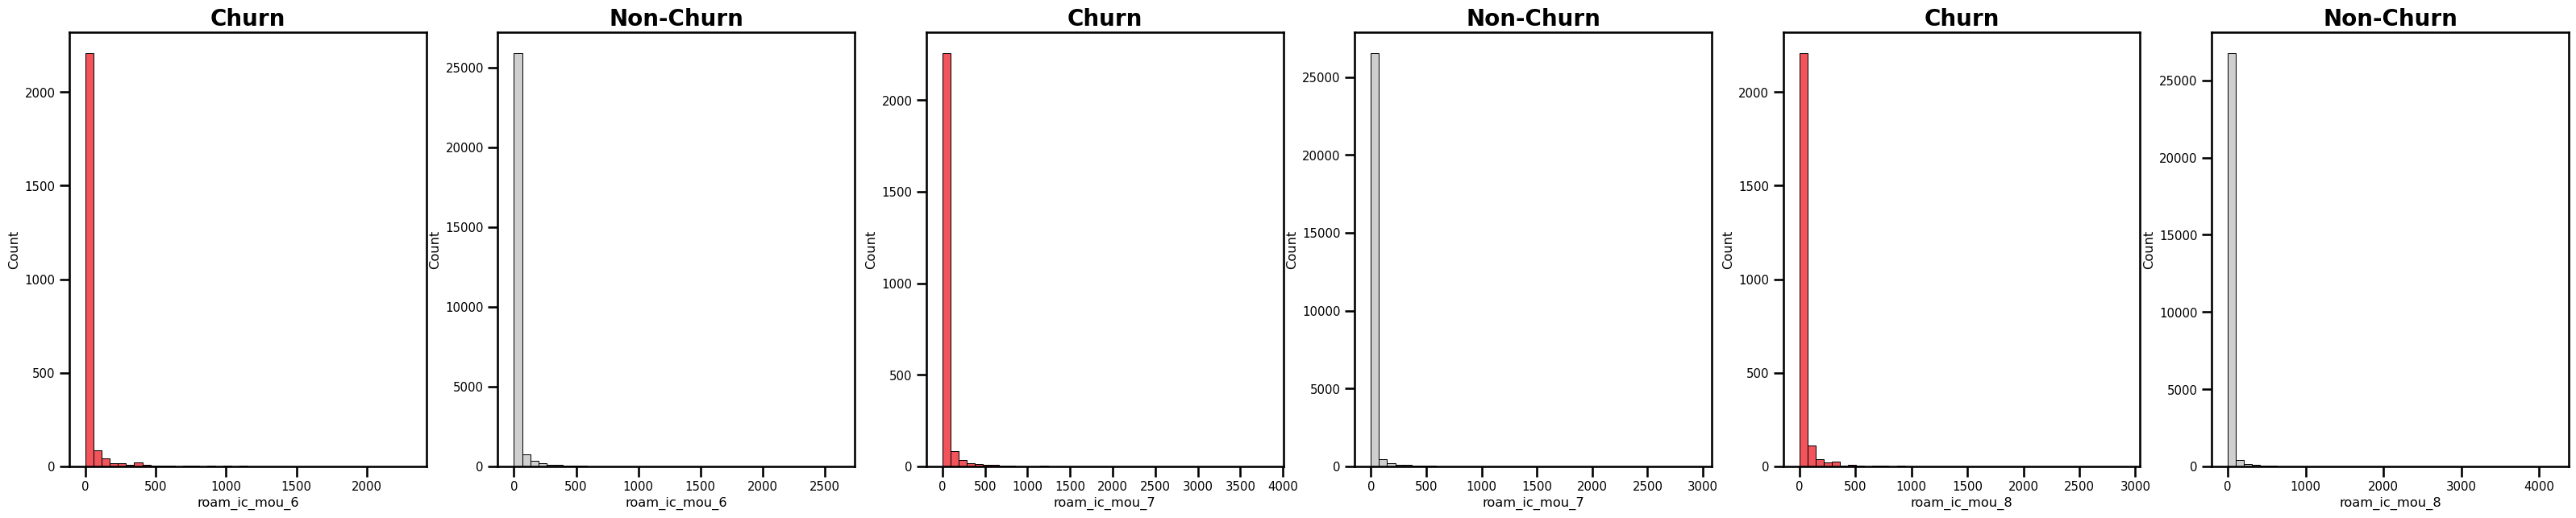

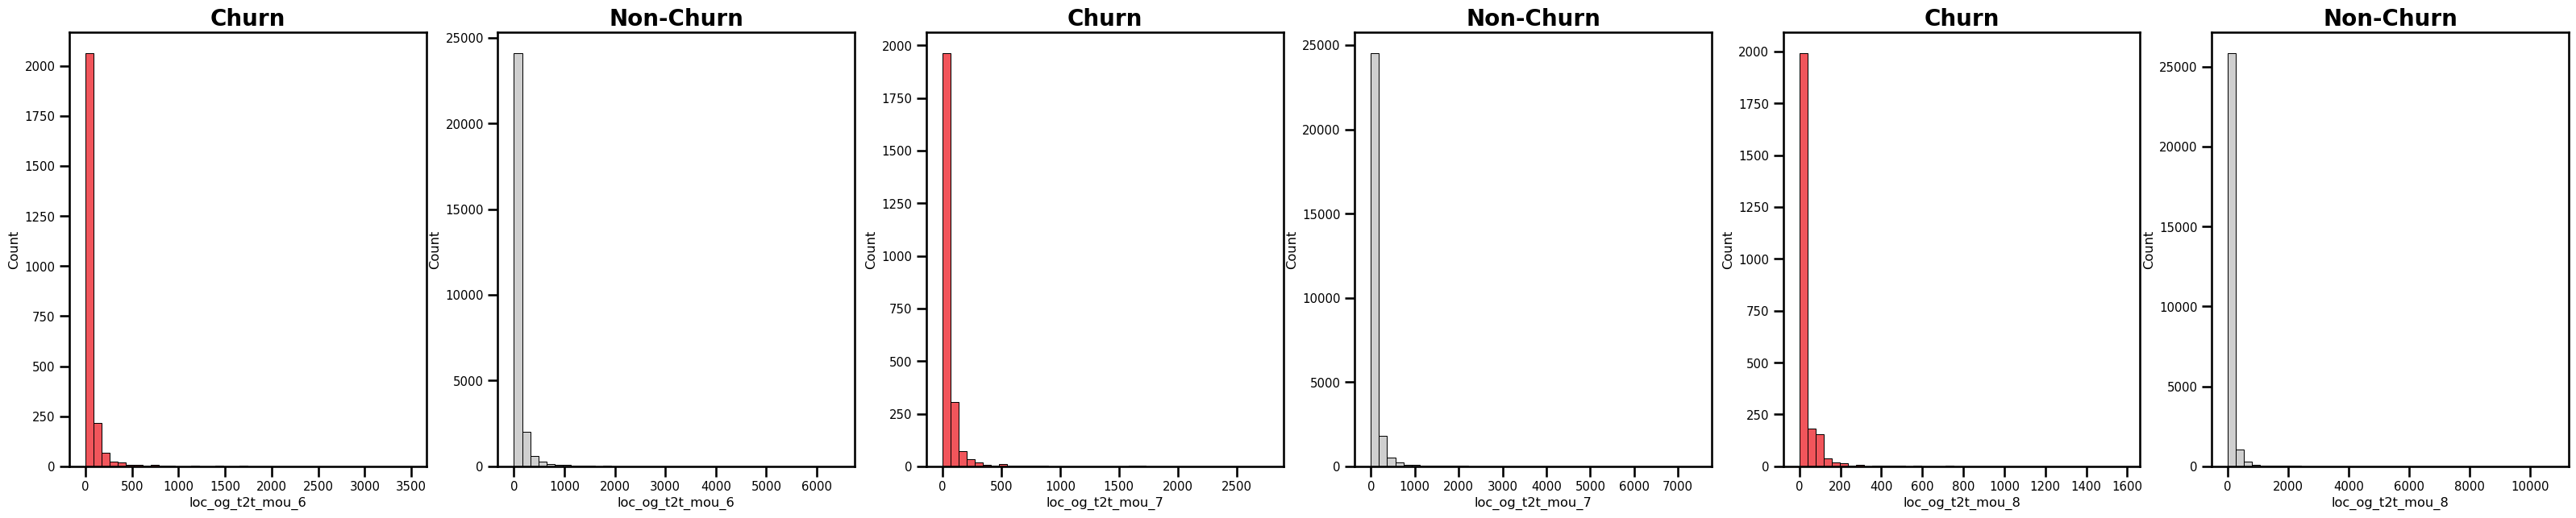

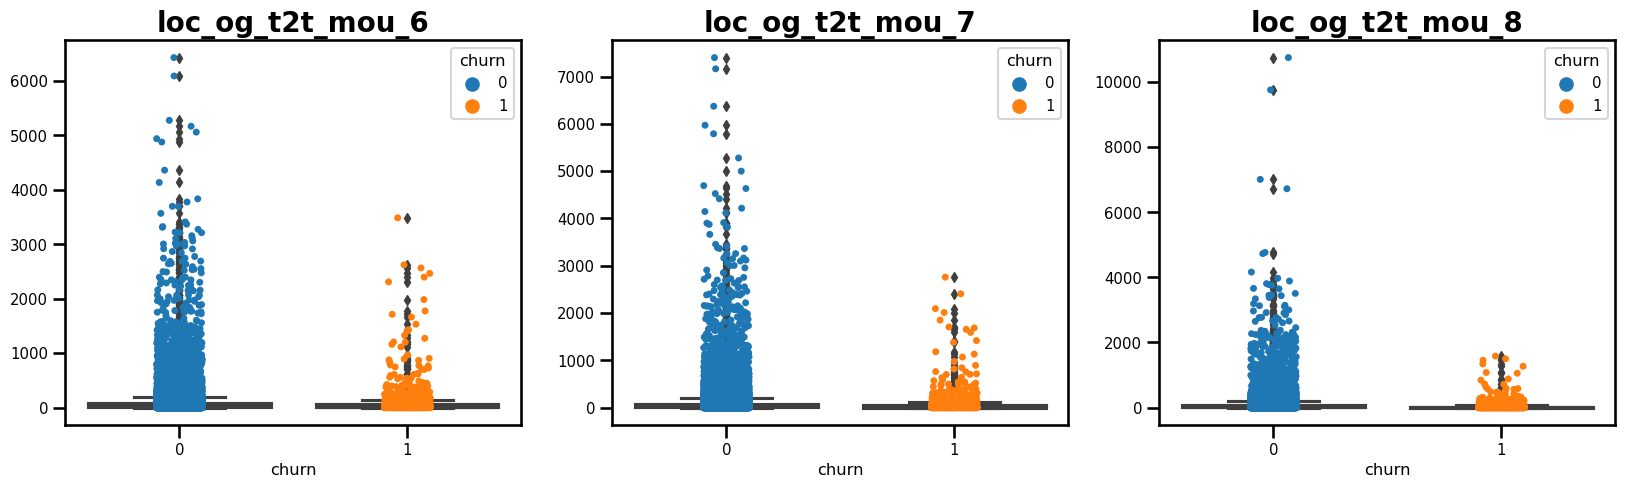

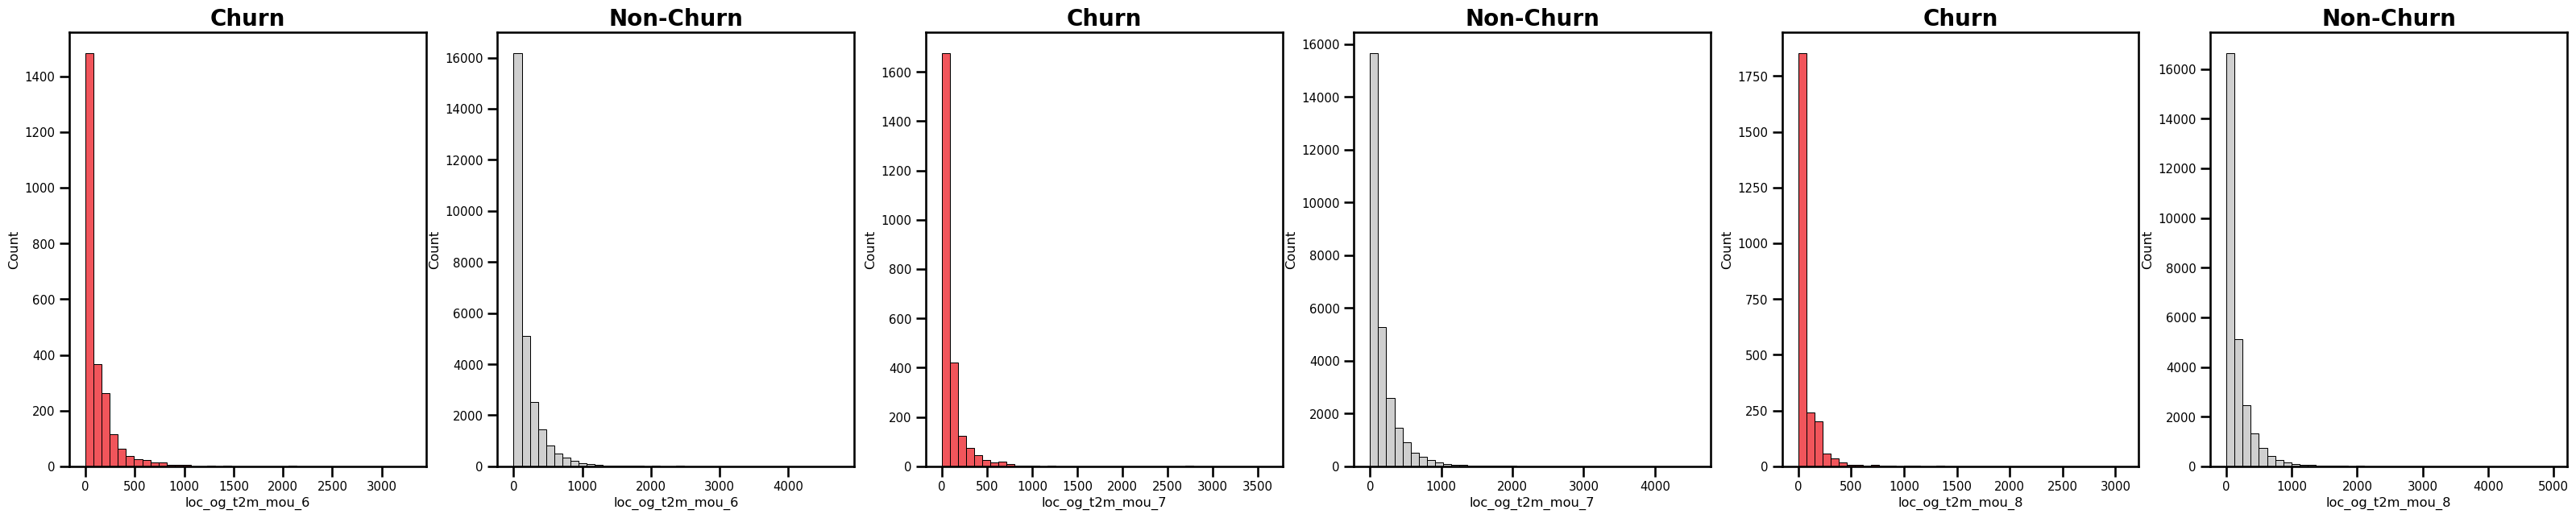

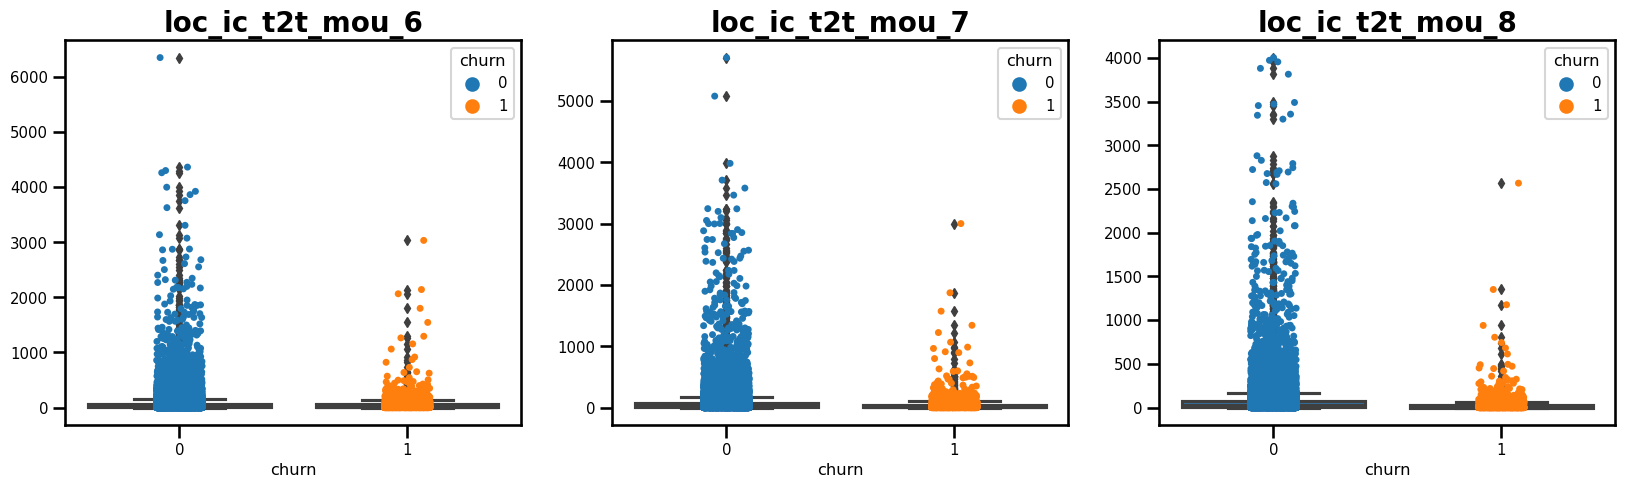

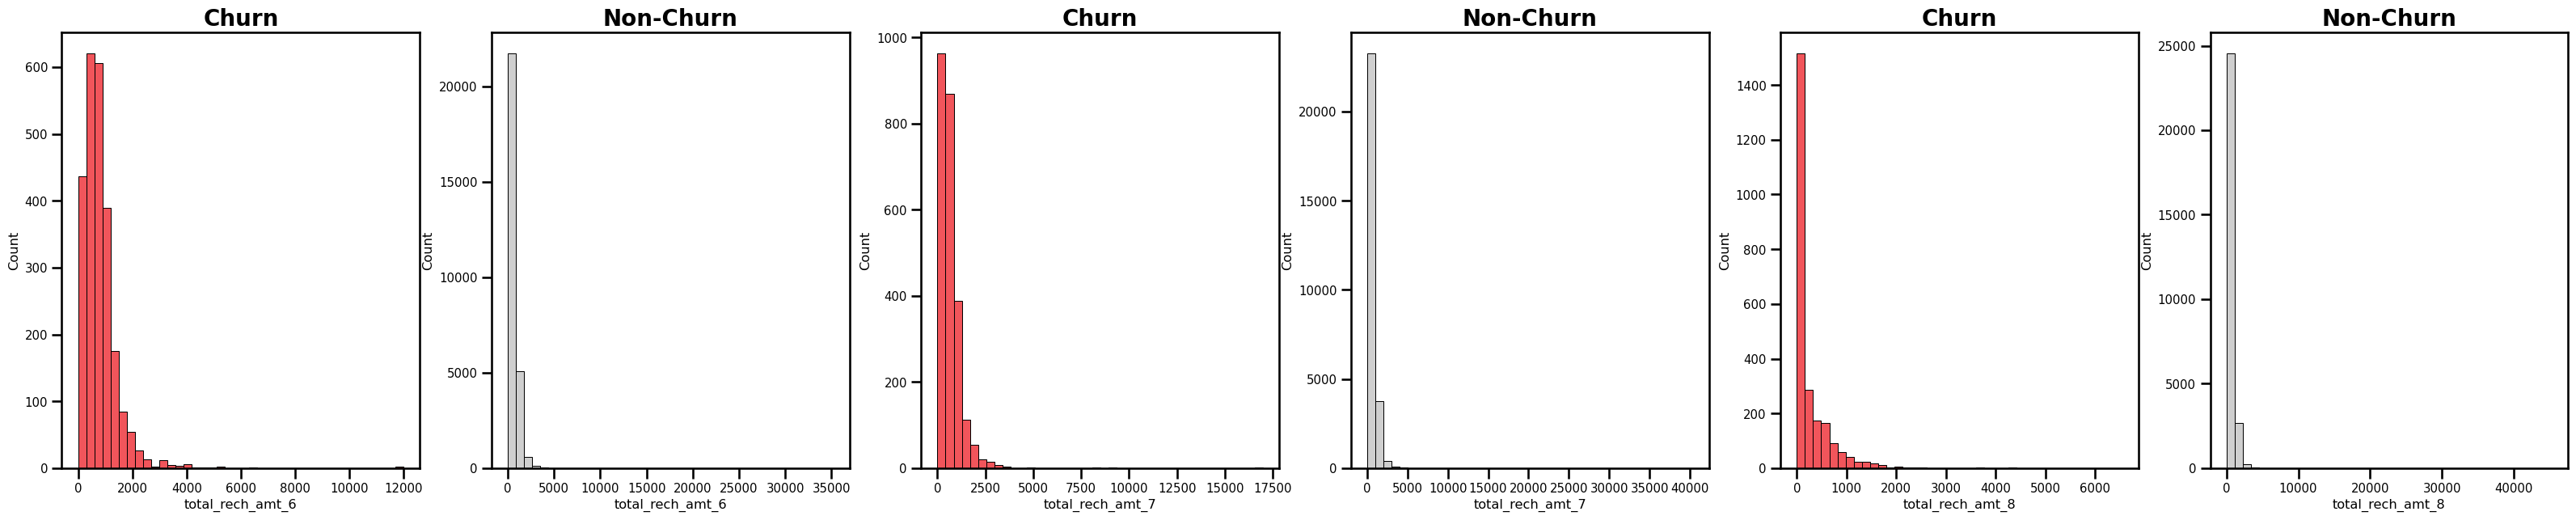

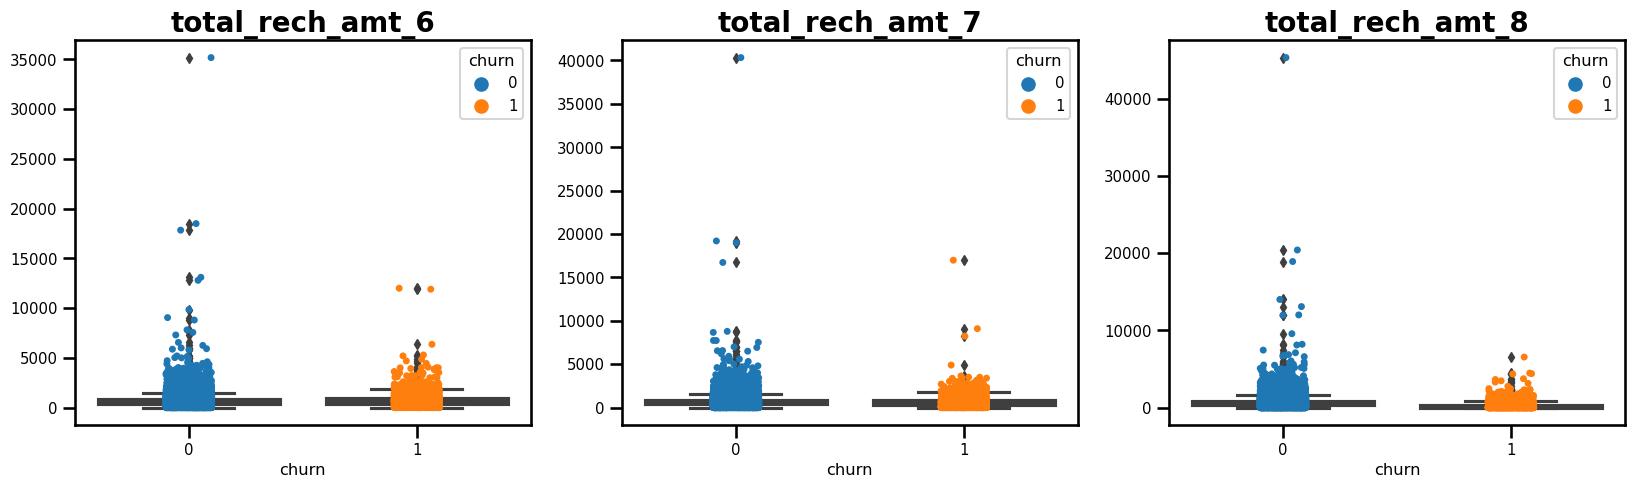

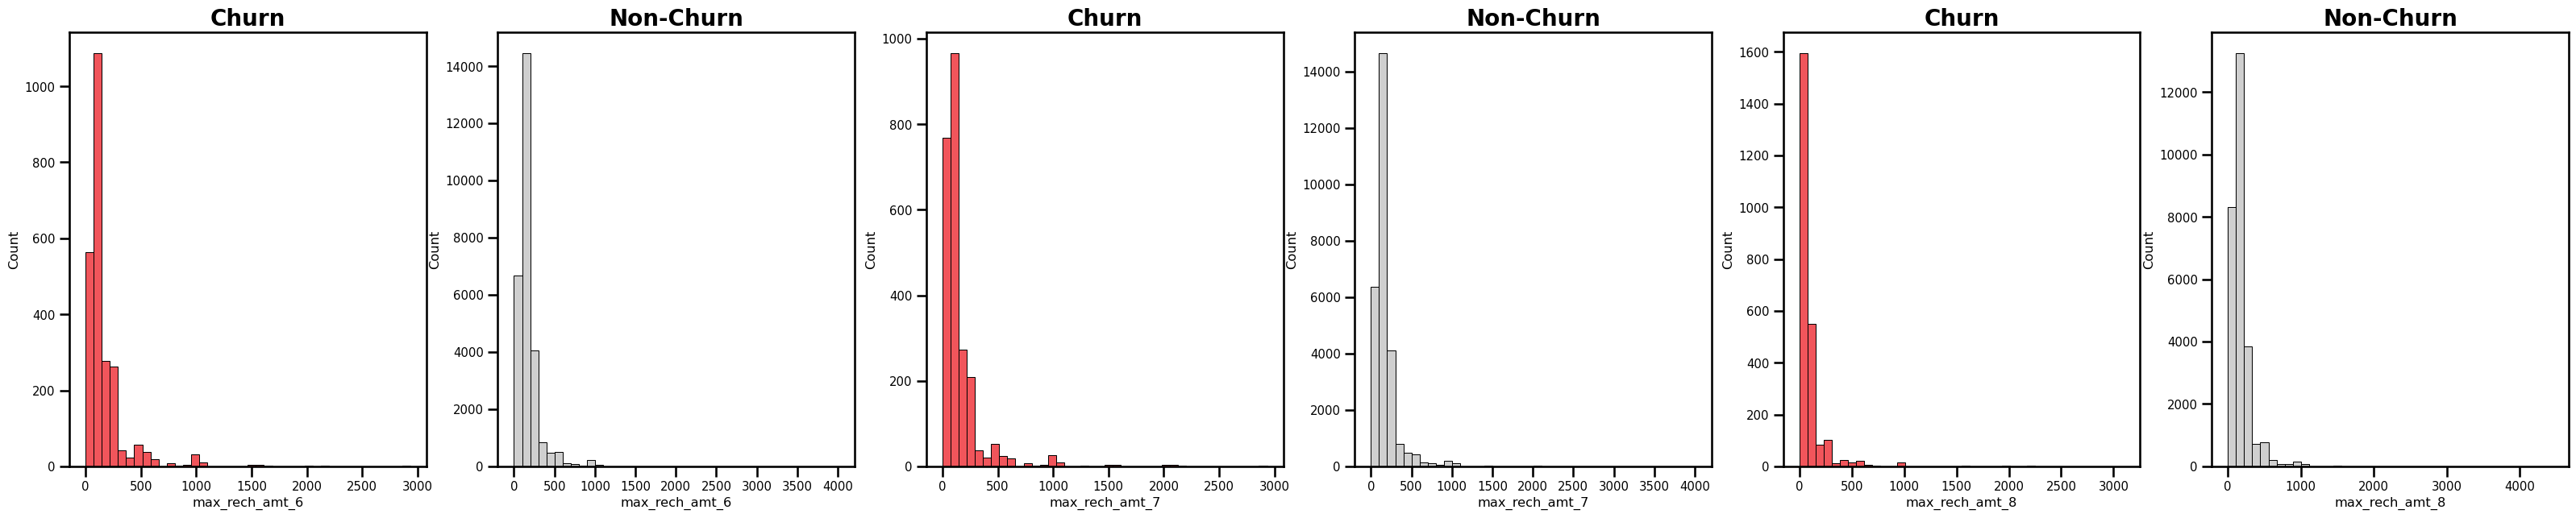

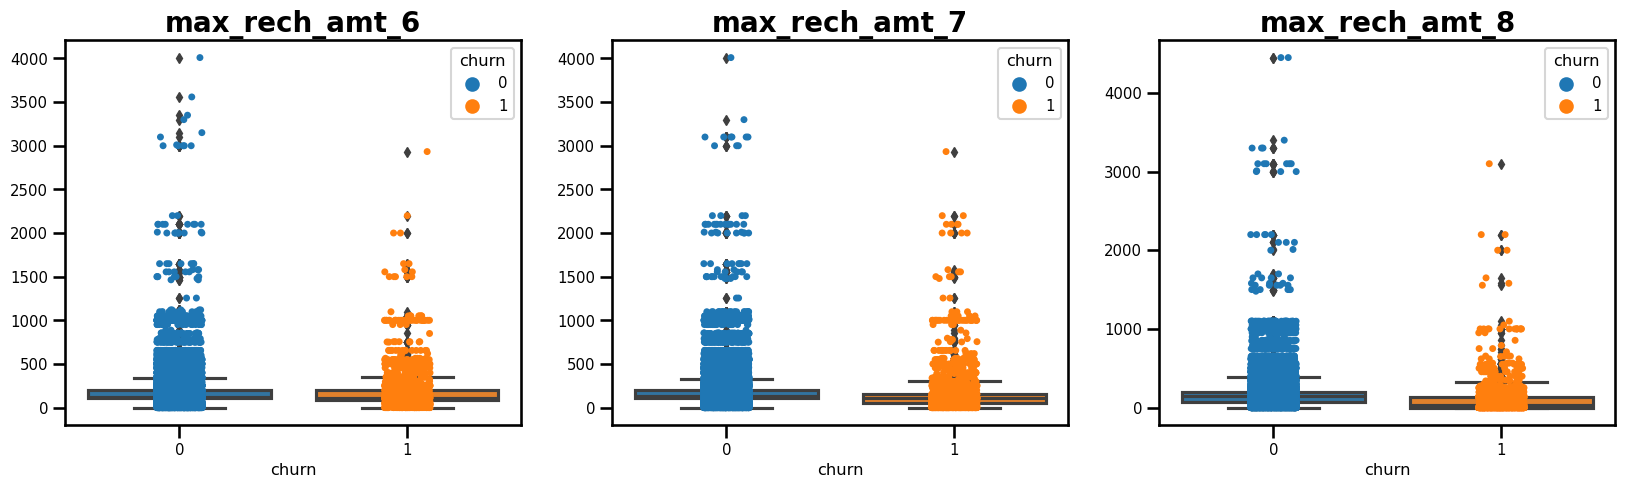

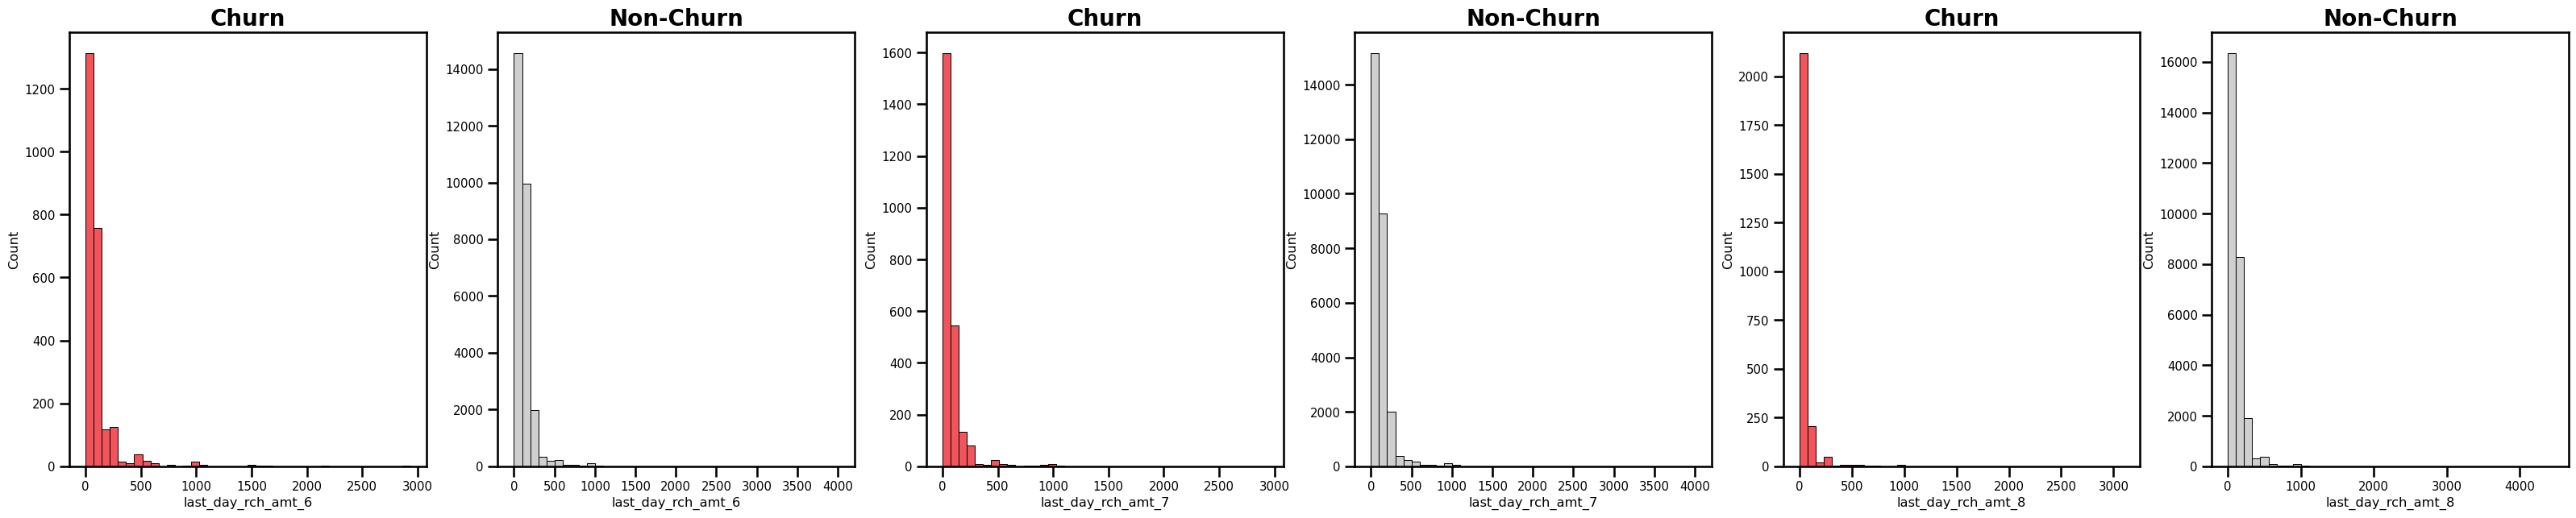

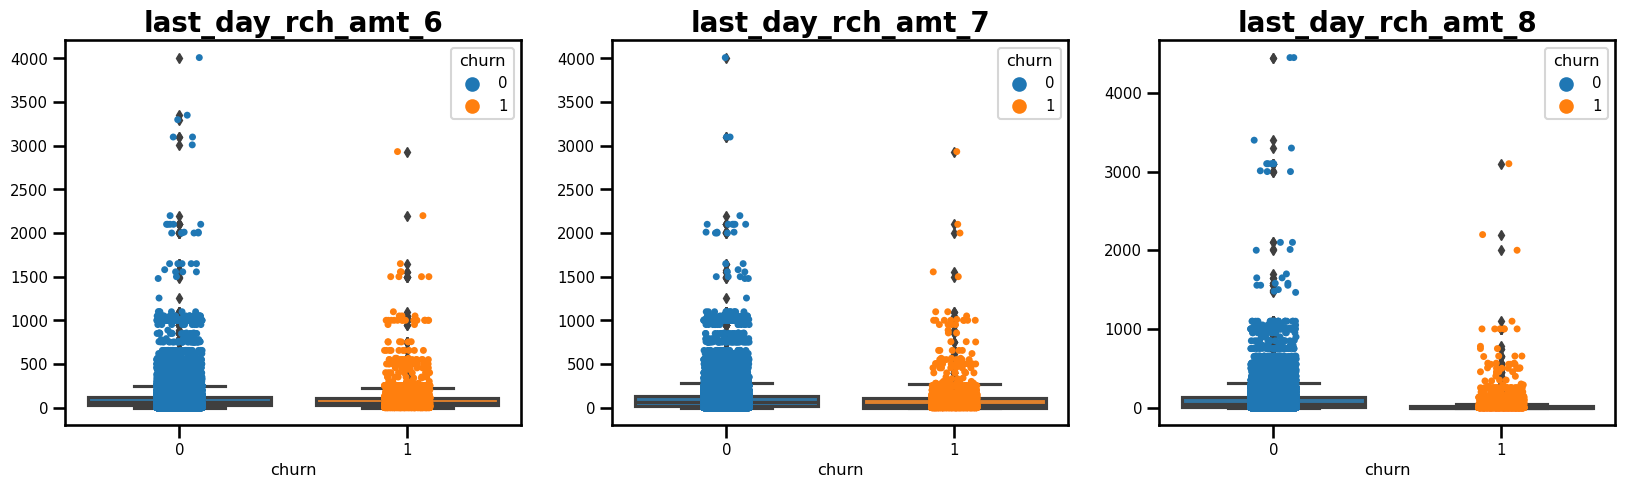

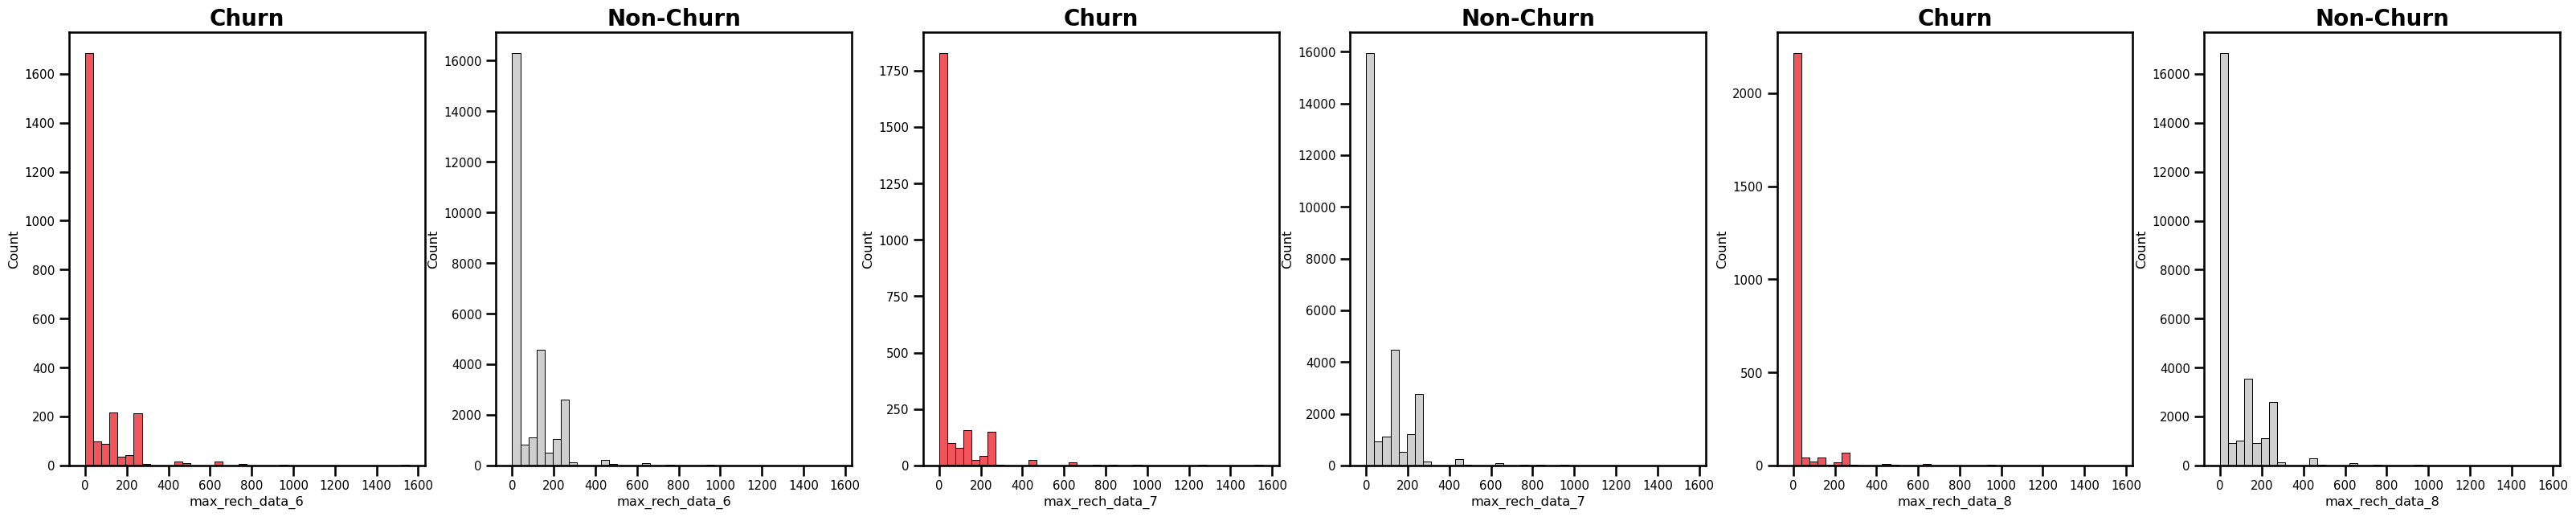

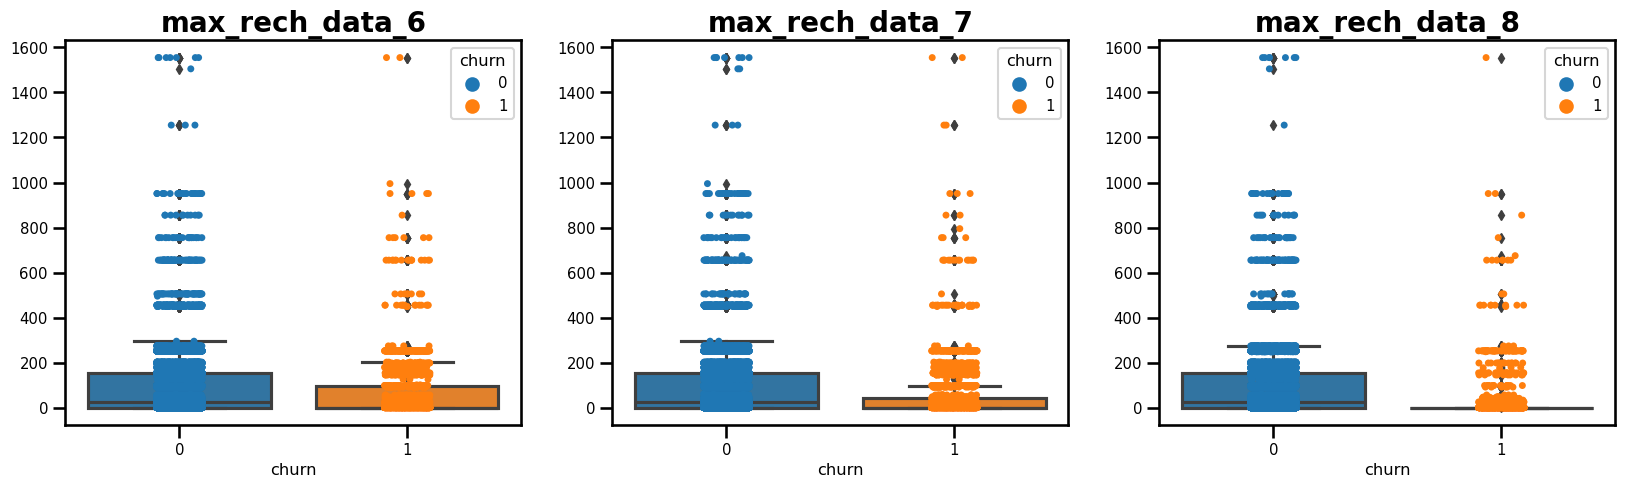

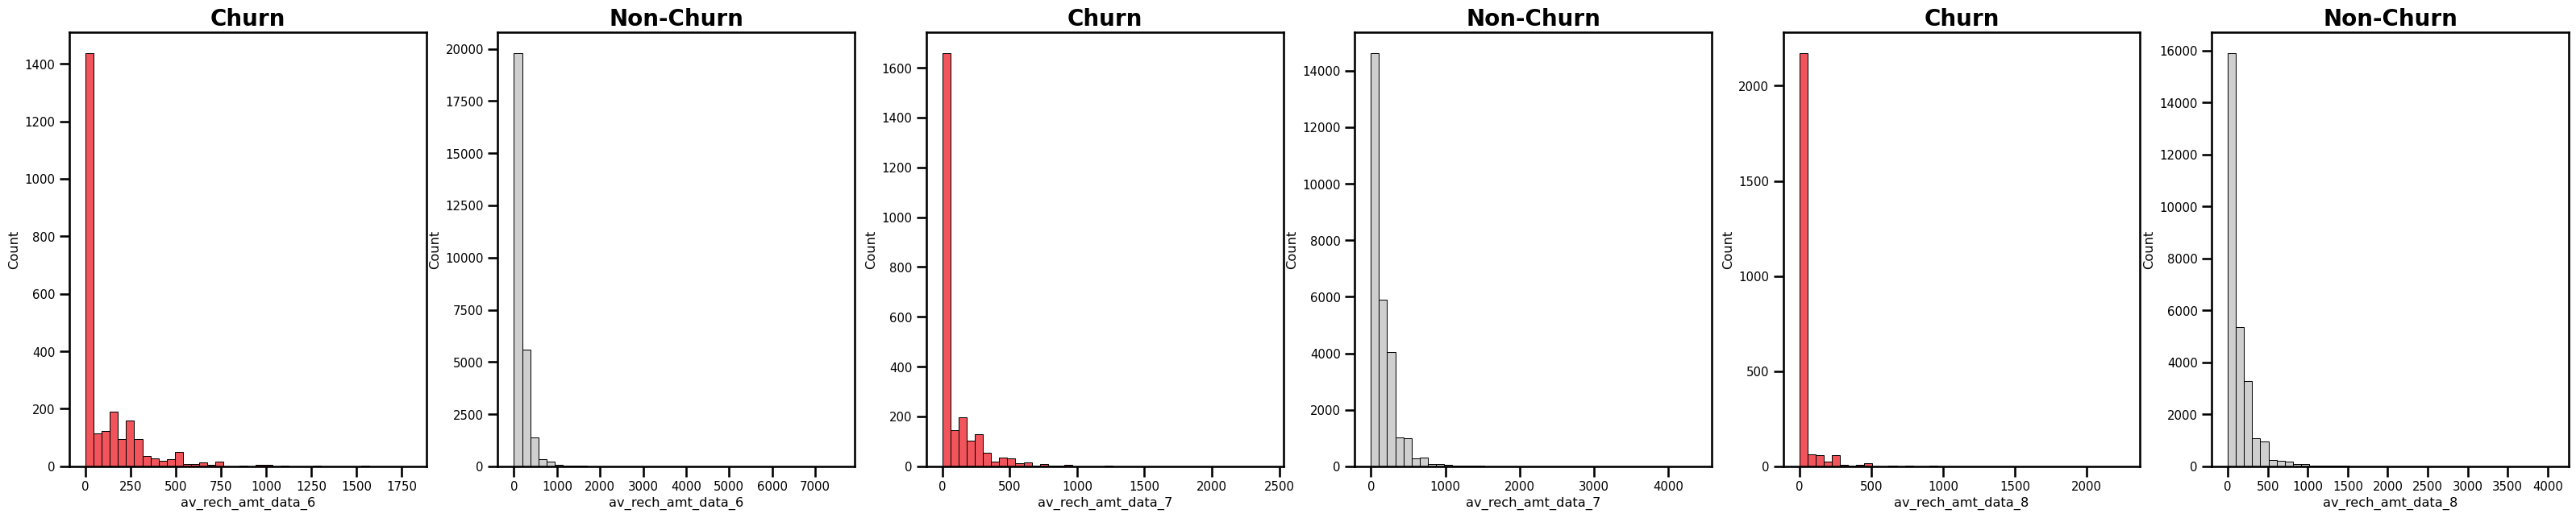

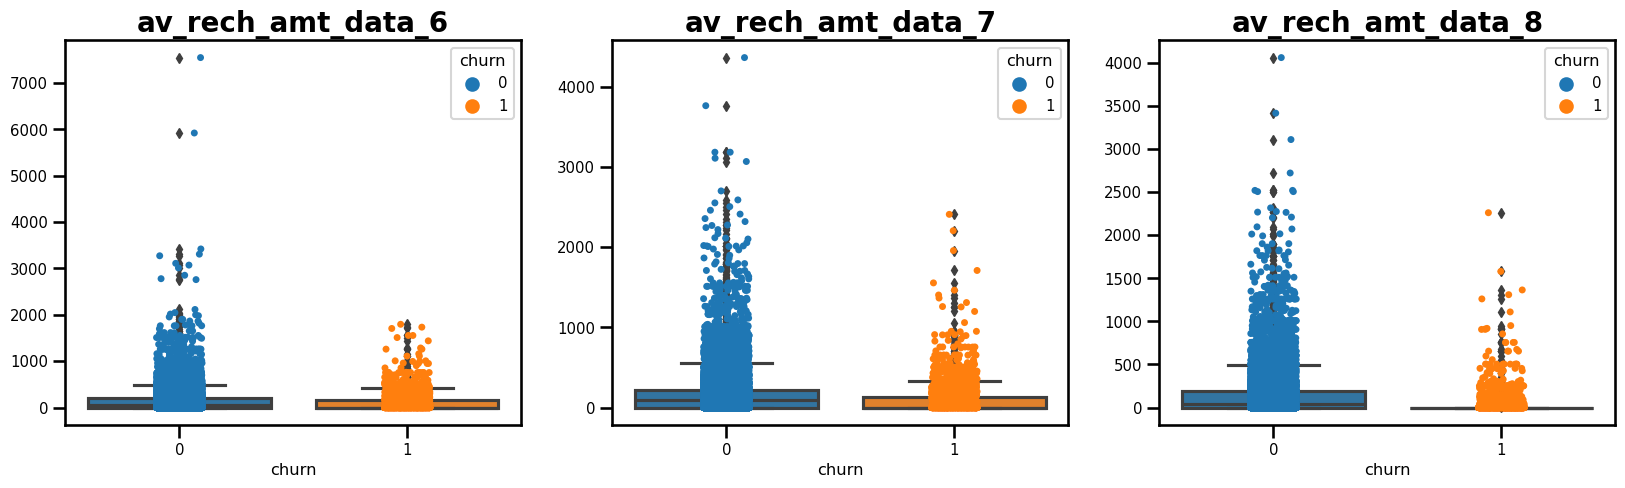

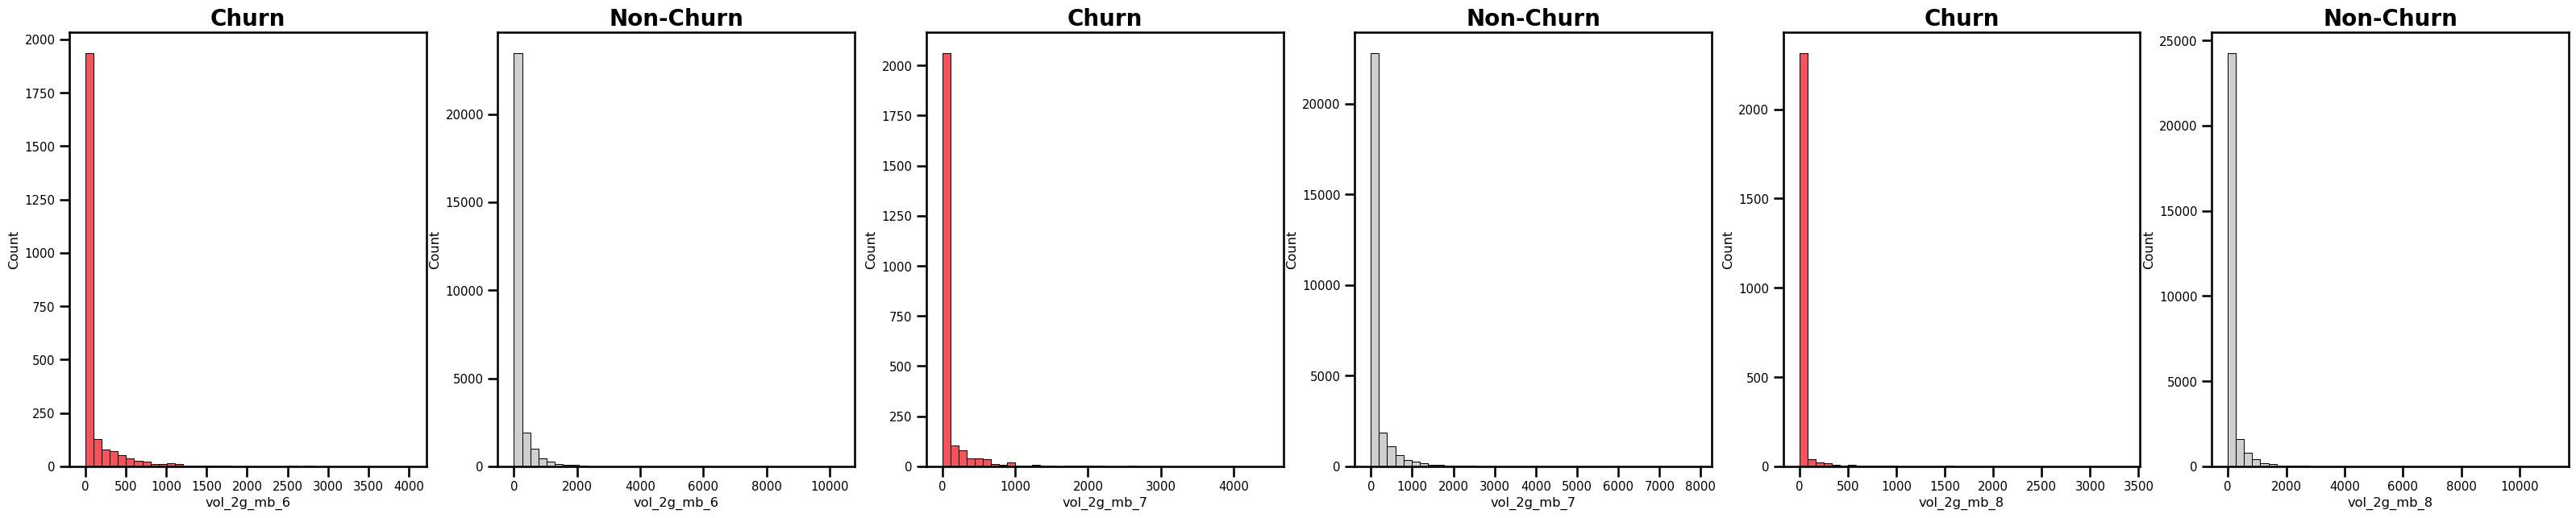

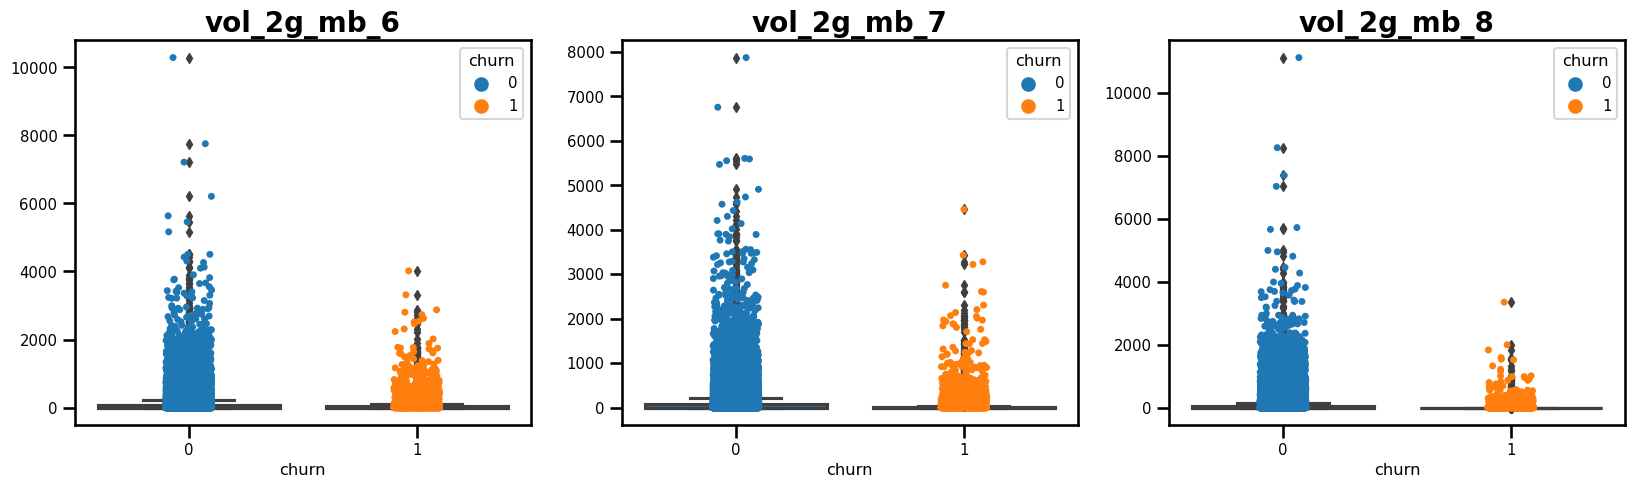

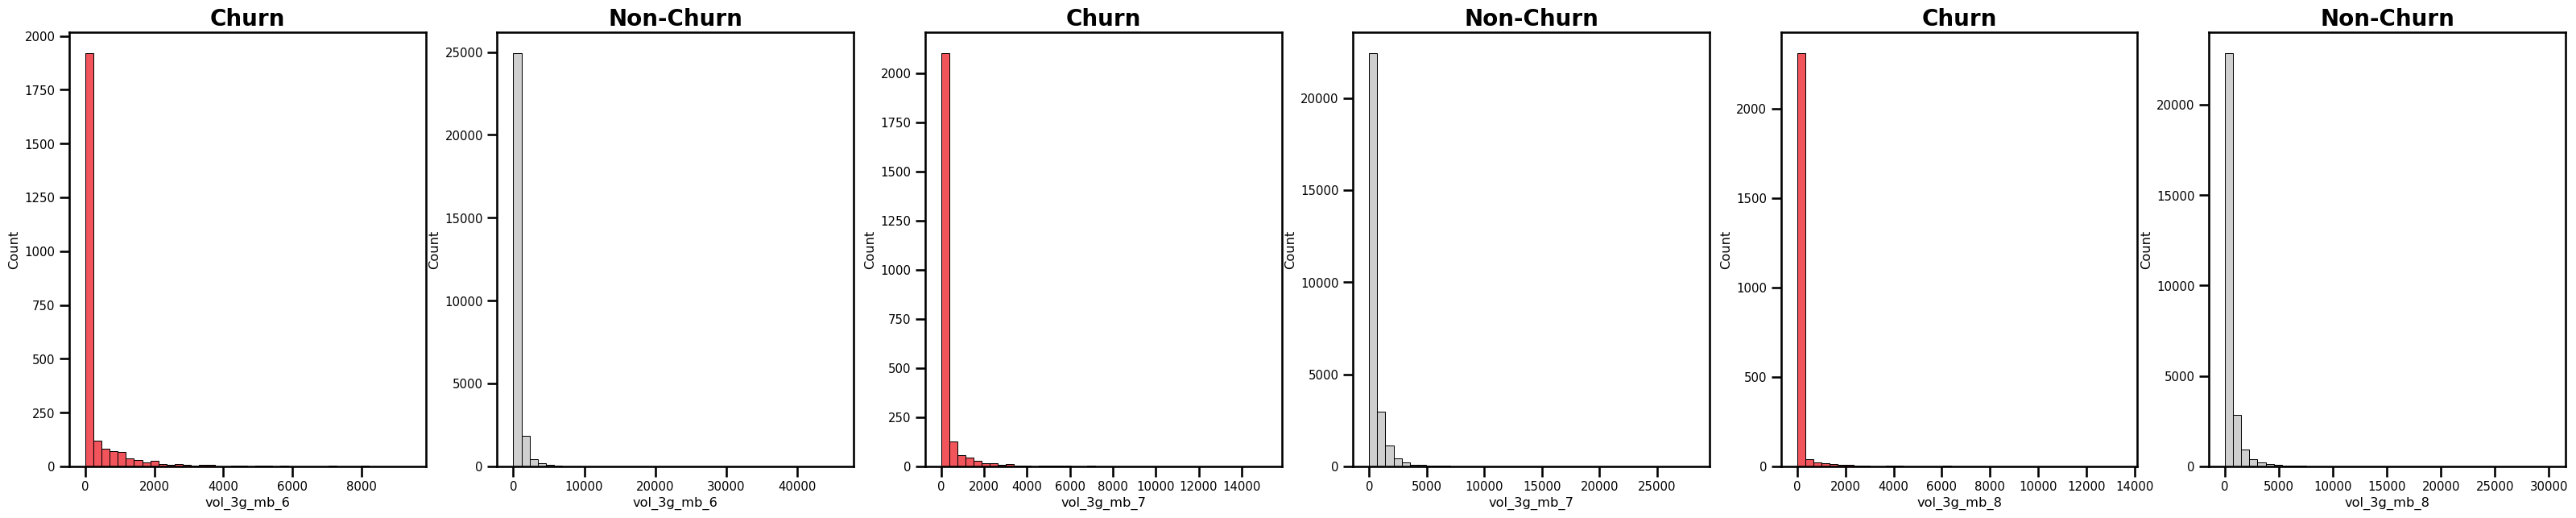

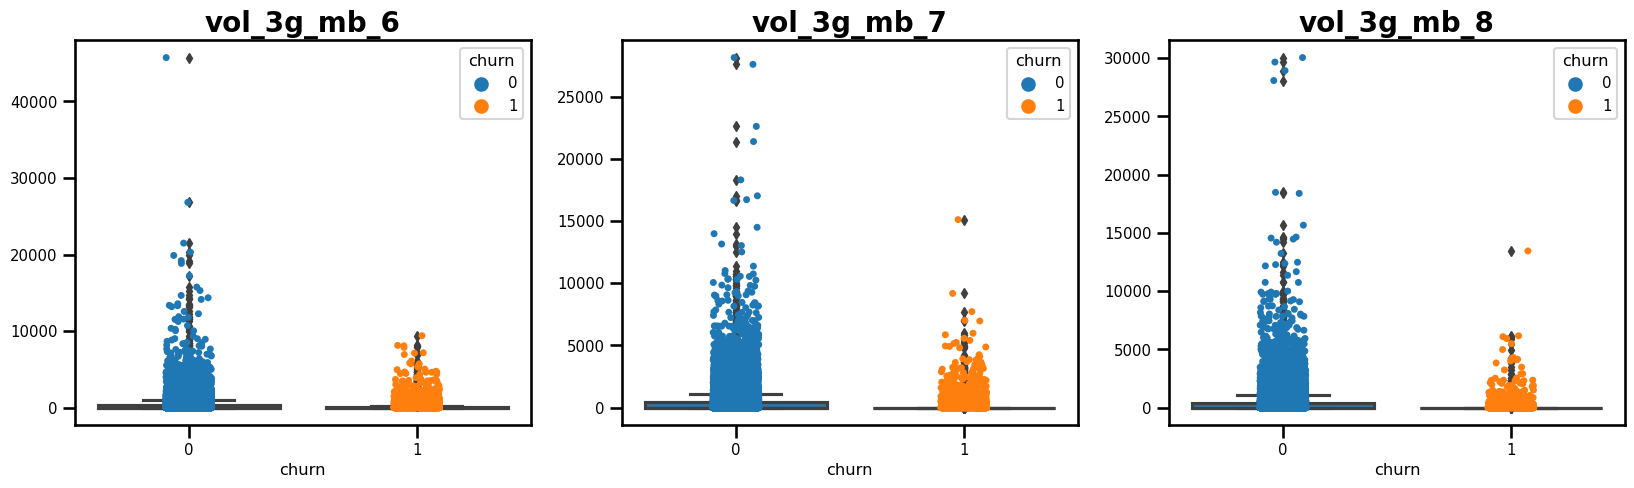

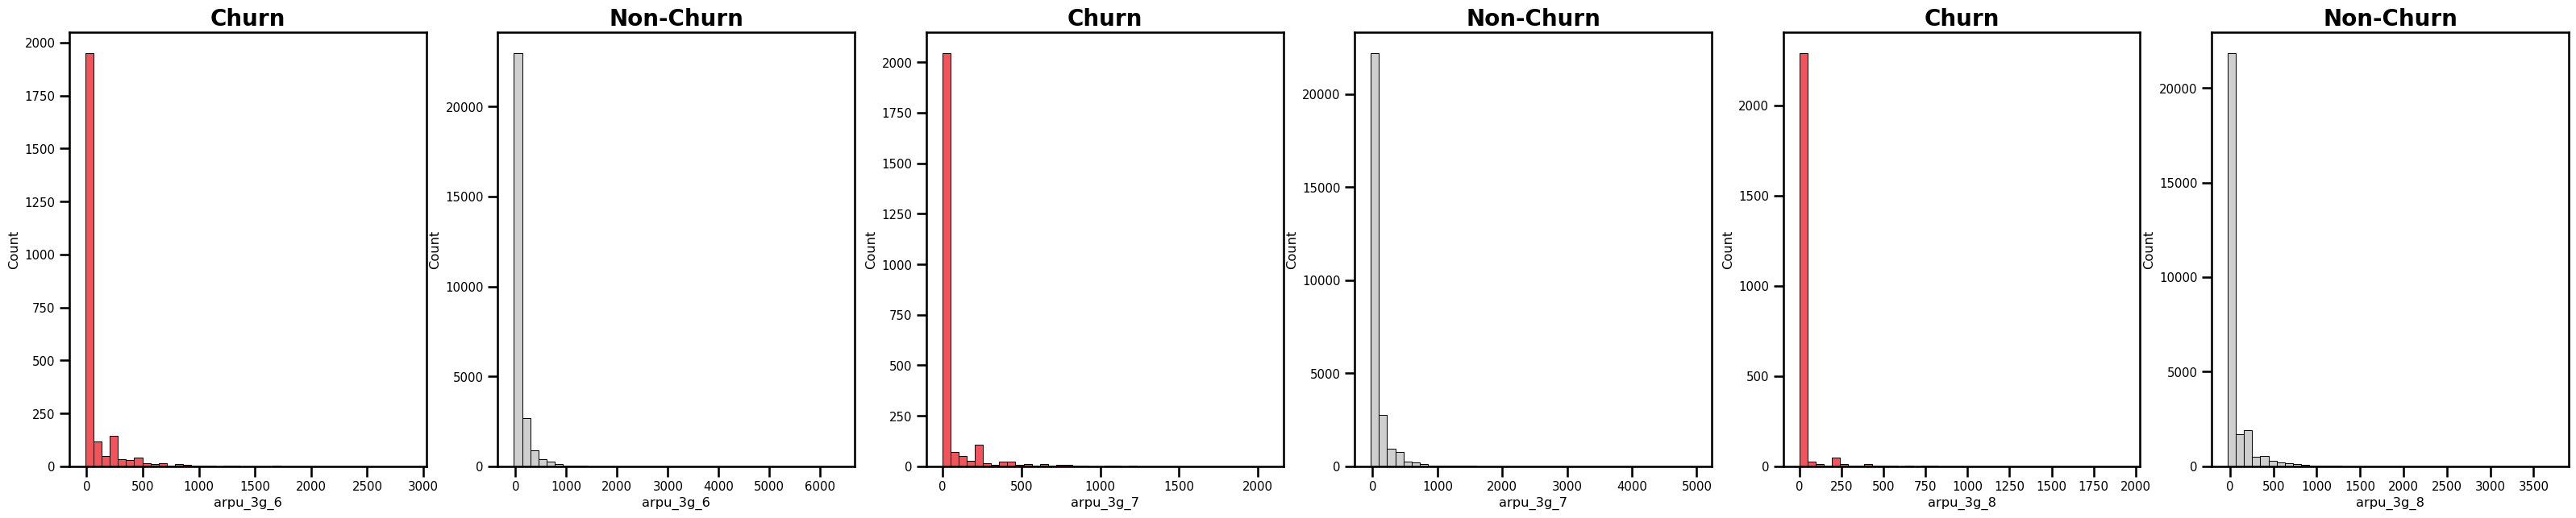

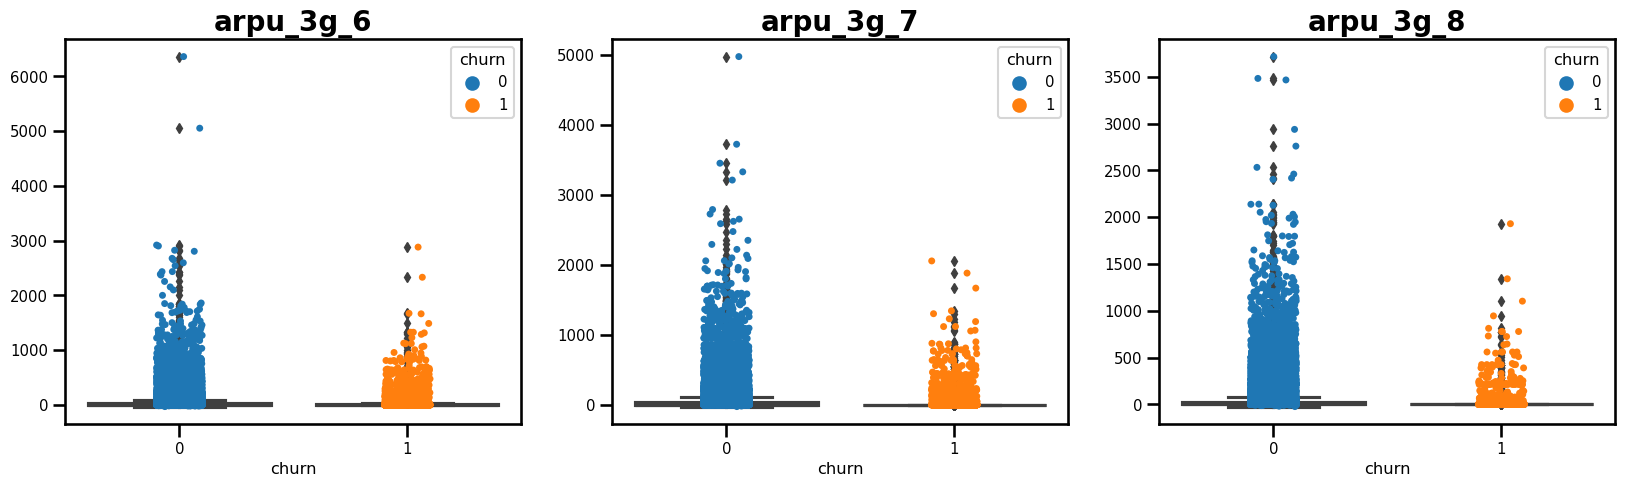

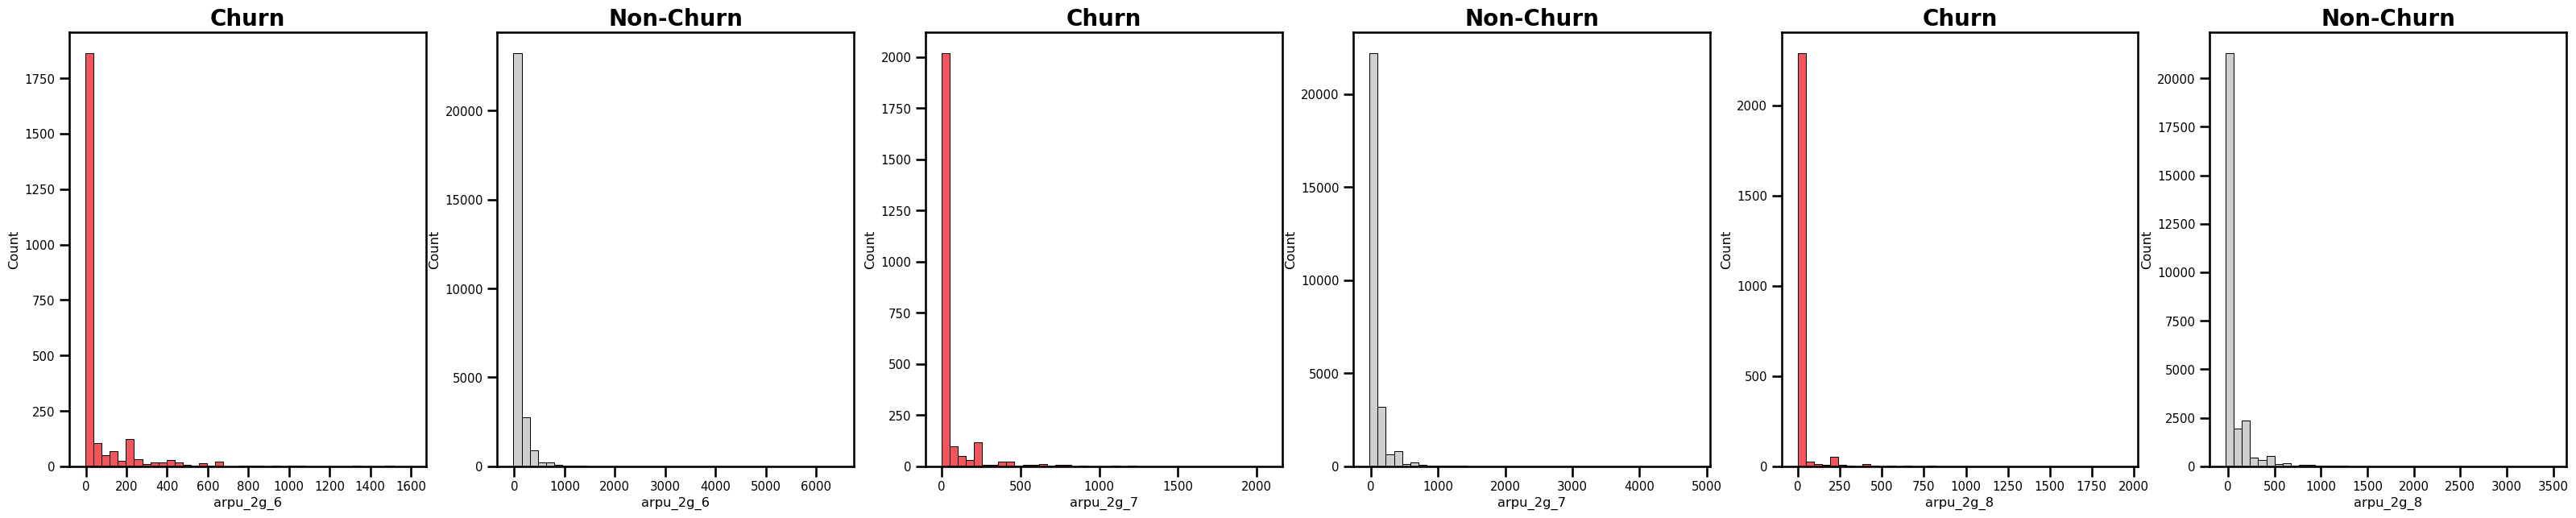

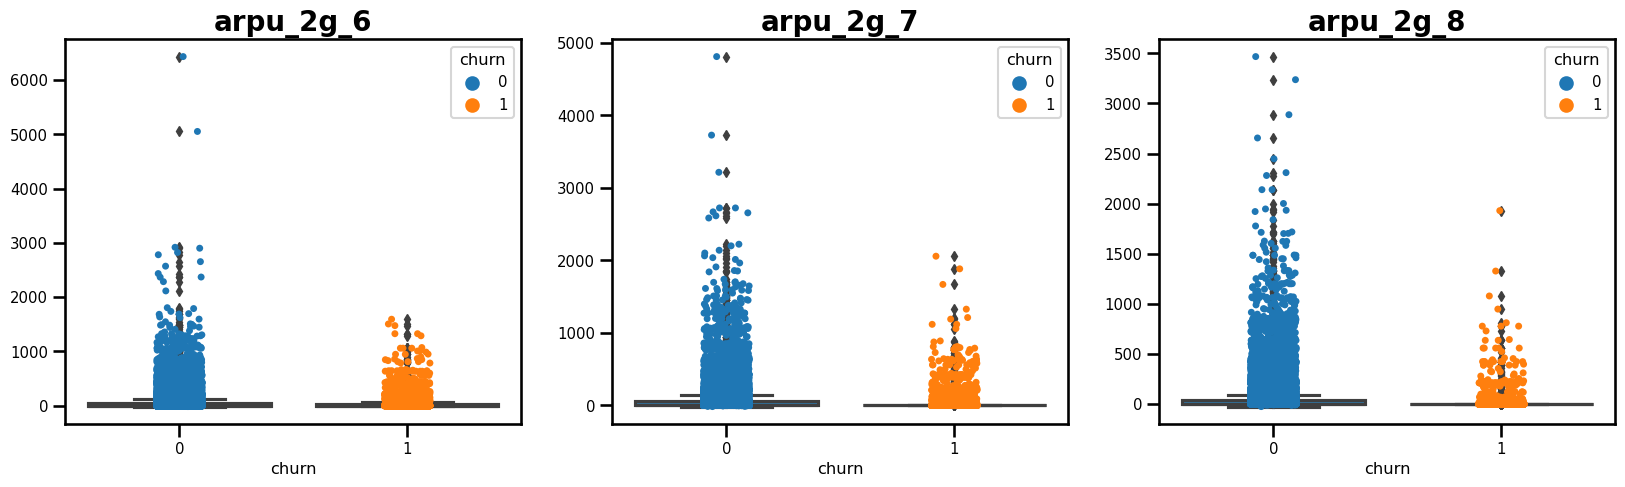

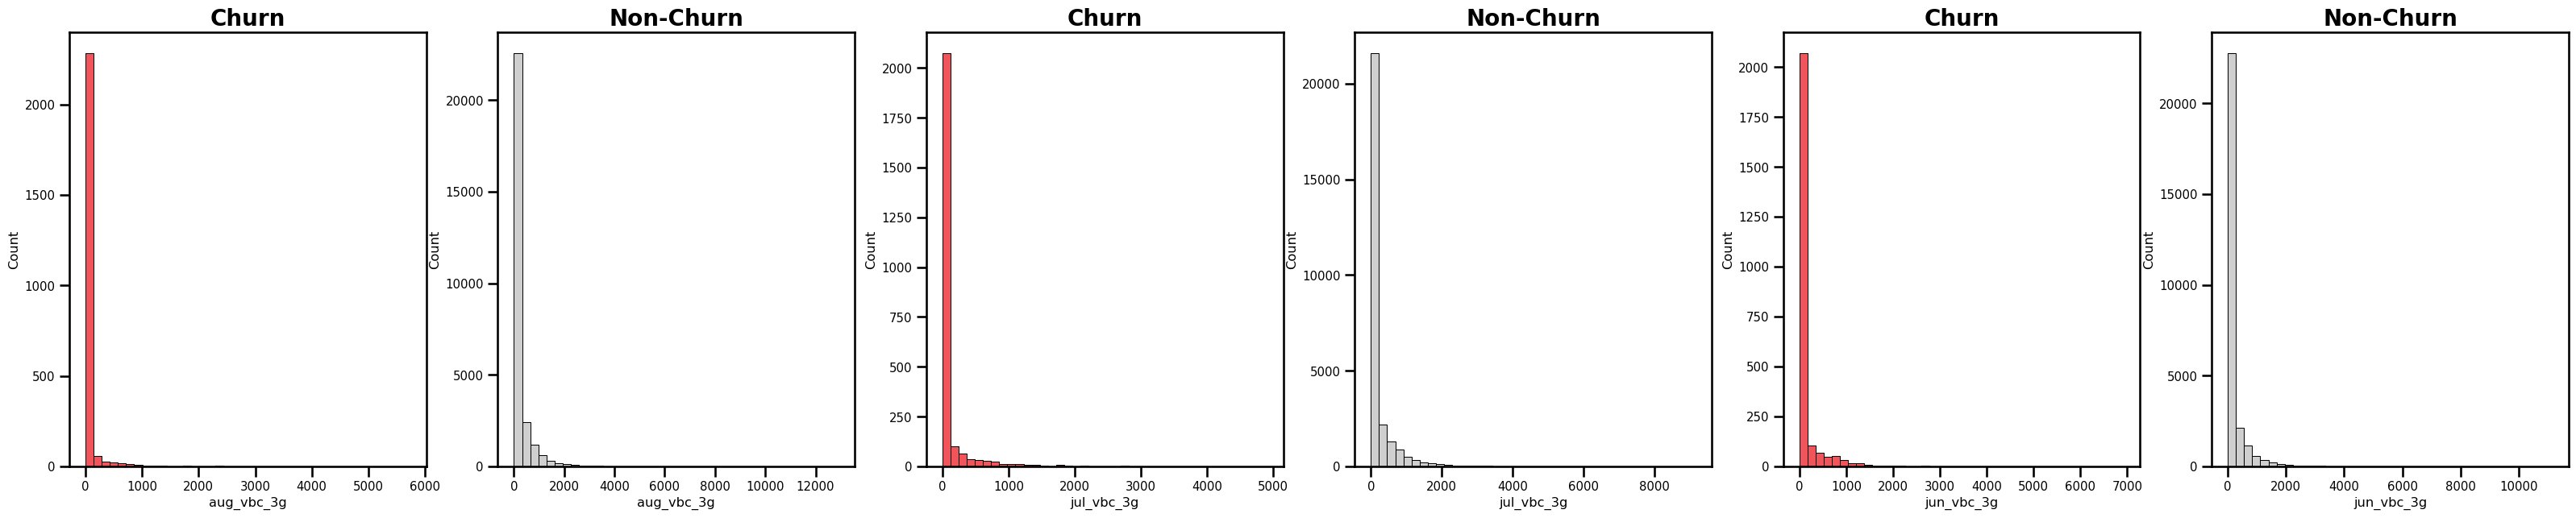

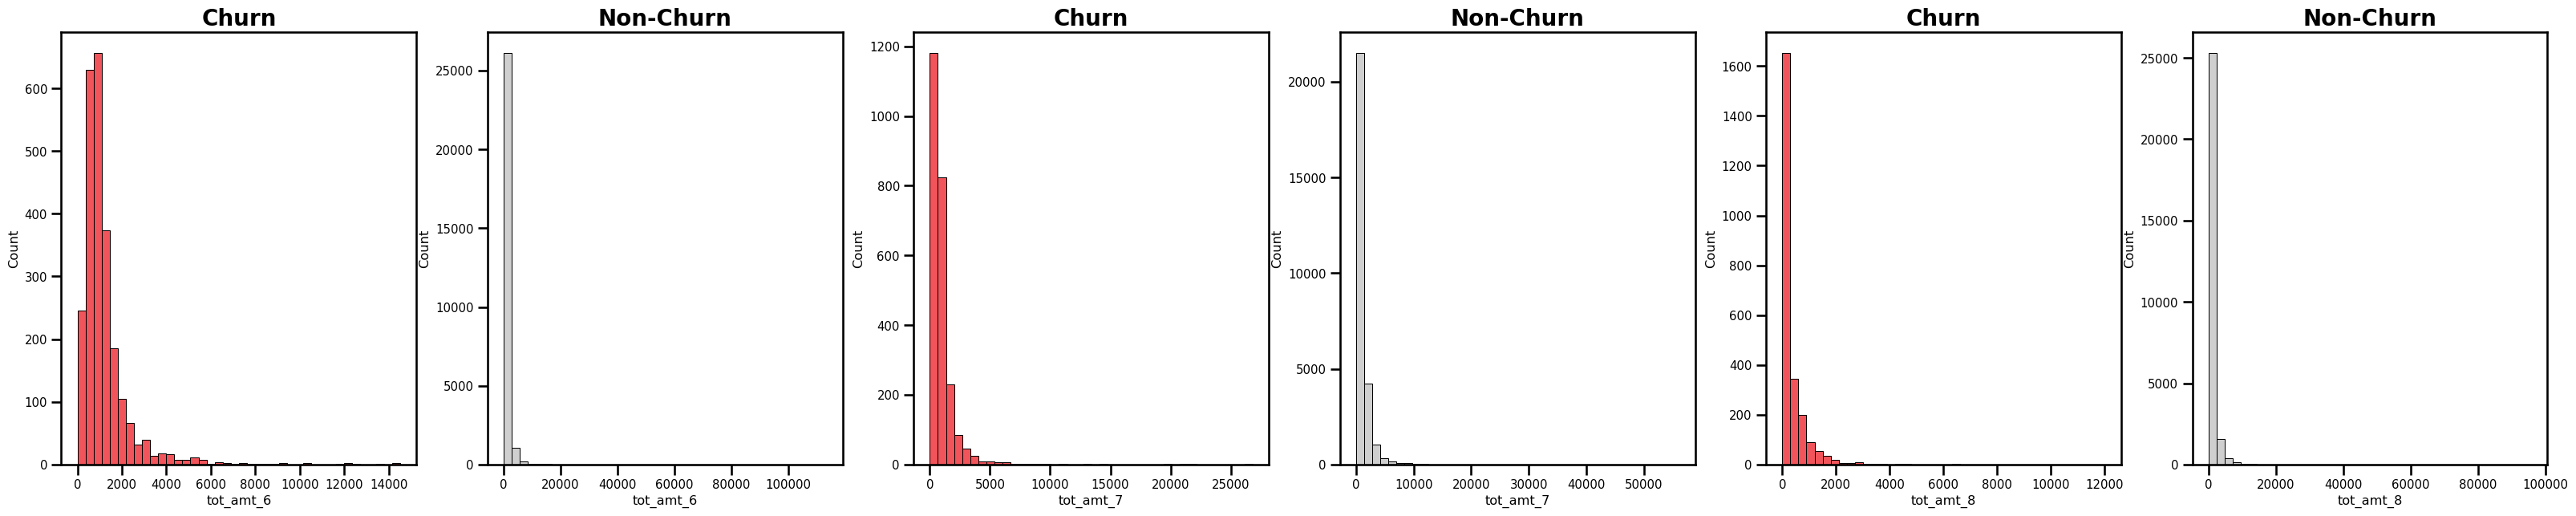

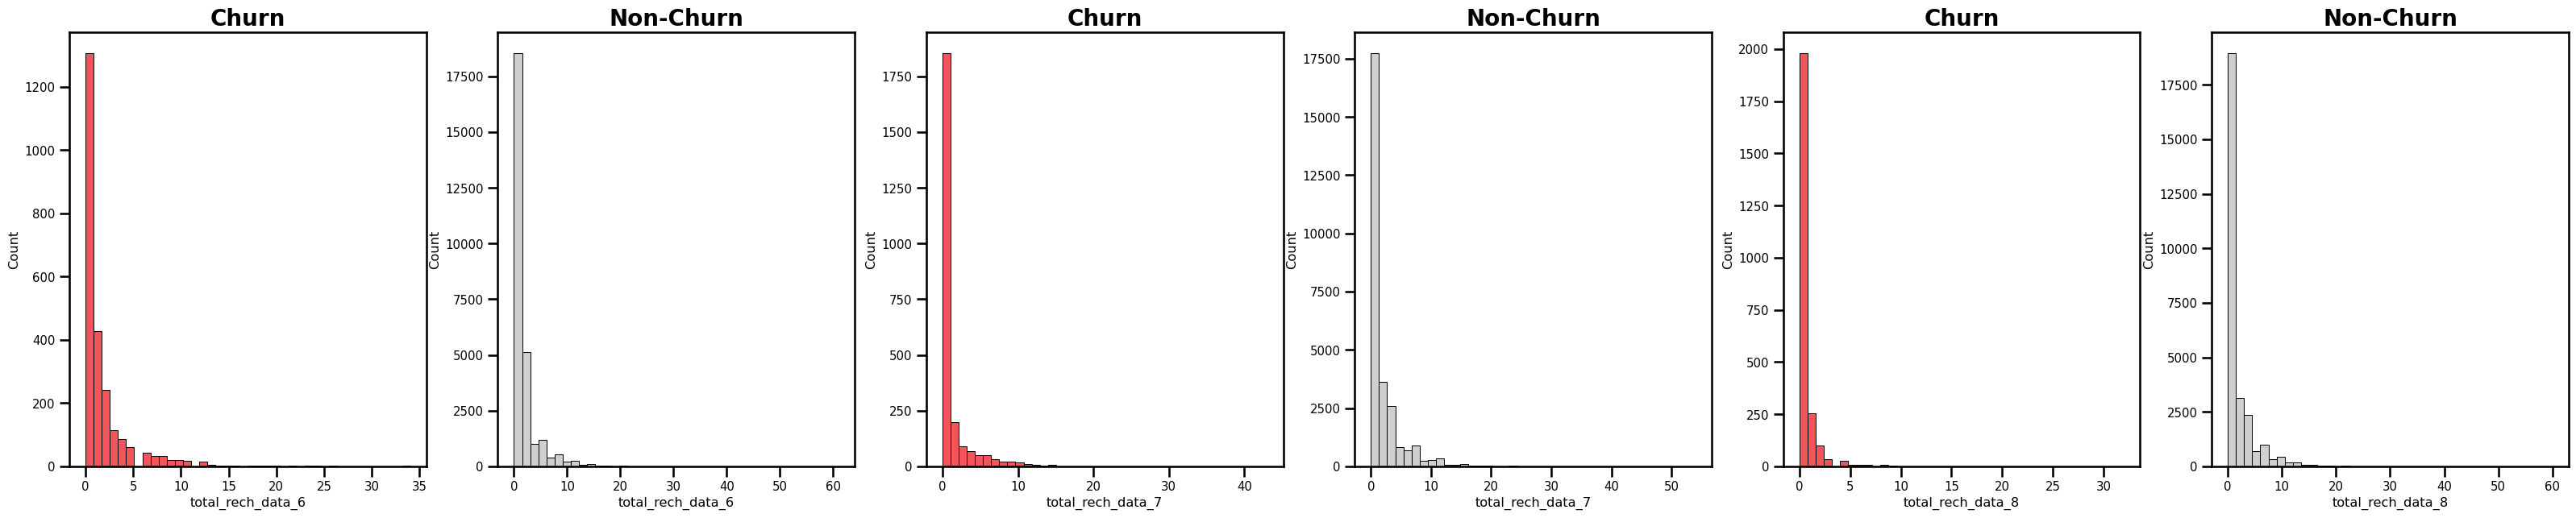

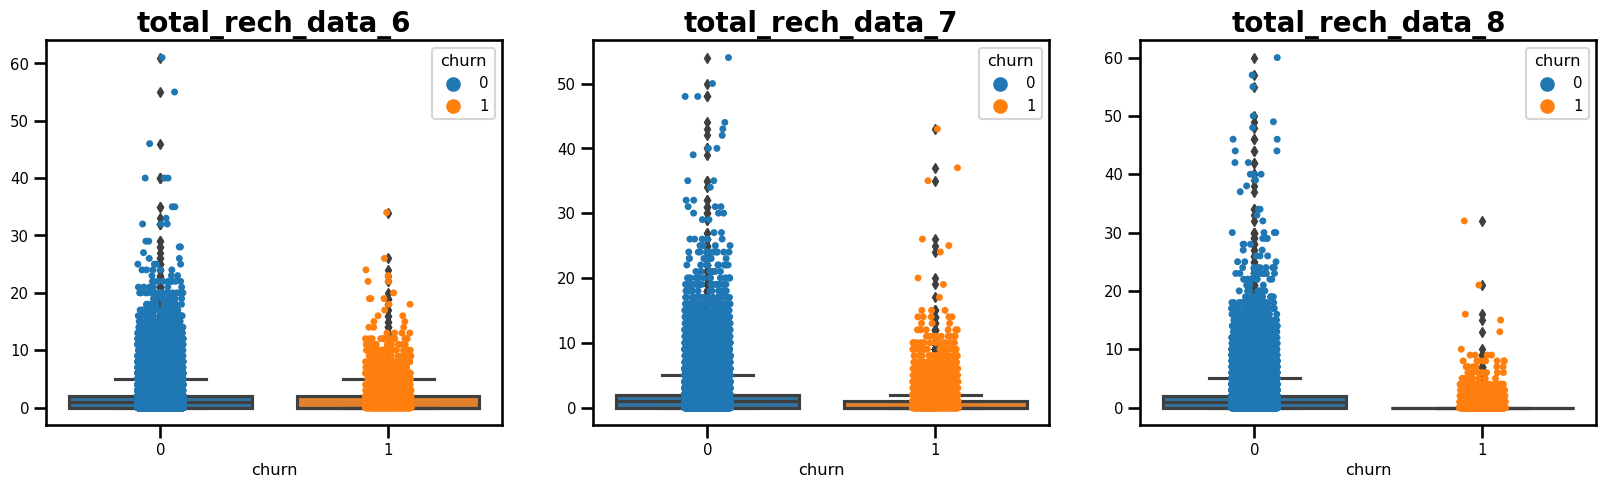

In [34]:
def plot_all_telcols(df, columns):
    for i in range(0, len(columns), 3):
        col1 = columns[i]
        col2 = columns[i+1] if i + 1 < len(columns) else None
        col3 = columns[i+2] if i + 2 < len(columns) else None
        
        if col1 and col2 and col3:
            dist_box_plot(telecom, col1, col2, col3)

plot_all_telcols(telecom, inc_cols)

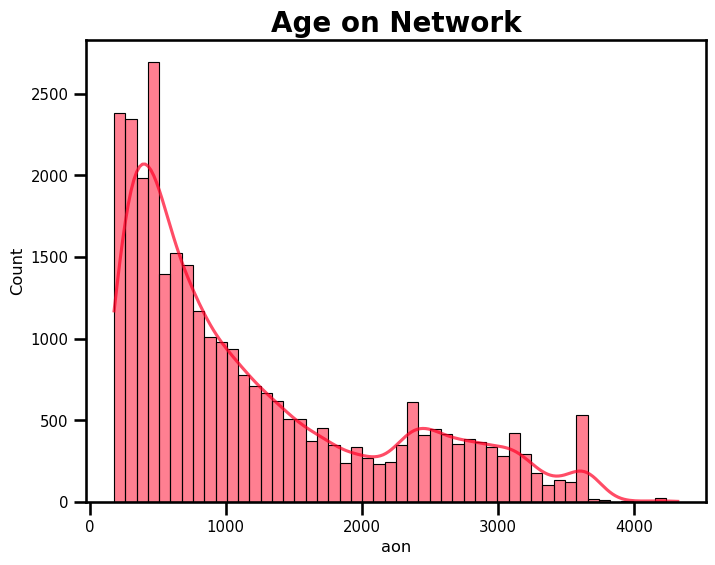

In [35]:
plt.figure(figsize=(8,6))
ax = sns.histplot(telecom['aon'], color='#FF0025', kde=True, line_kws={'alpha':.7})
ax.set_title('Age on Network', fontweight='bold', size=20)
plt.show()

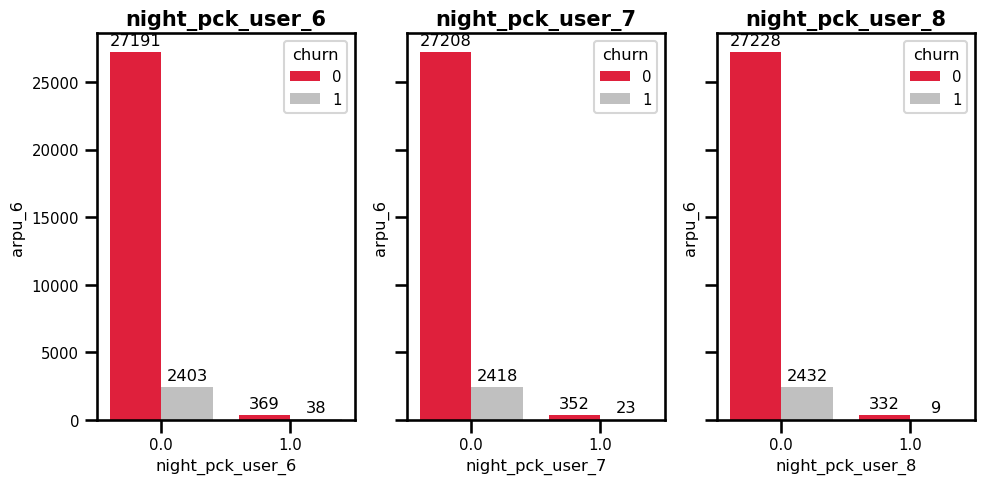

In [36]:
# def showvalues(axs): # Function to show values in barplot
#     for ax in axs:
#         for p in ax.patches:
#             _x = p.get_x() + p.get_width() /2
#             _y = p.get_y() + p.get_height()
#             value = f'{p.get_height():.1f}'
#             ax.text(_x, _y, value, ha="center", fontweight='bold', fontsize=9)

def dist_bar_plot(df, columns, yaxis):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(10, 5), sharey=True, layout='constrained')
    color = ['#FF0025', '#C0C0C0']
    
    for ax, col in zip(axes, columns):
        df_temp = df.groupby([col, 'churn'])[yaxis].count().reset_index()
        sns.barplot(x=col, y=yaxis, hue='churn', data=df_temp, palette=color, ax=ax)
        # showvalues([ax])
        for i in ax.containers: # Alt method to show values in barplot
            ax.bar_label(i, rotation=0, padding=3)
        ax.set_title(col, fontdict={'fontsize':15, 'fontweight':'bold'}, loc='center')
    
    plt.tight_layout()
    plt.show()

col1 = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
dist_bar_plot(telecom, col1, 'arpu_6')

> ARPU is increasing from 6th to 8th month for churn customers who hasn't taken Night Pack service. And ARPU is getting decreased from 6th to 8th month for night pack users. Means moslty churn customers have stopped their night pack facility

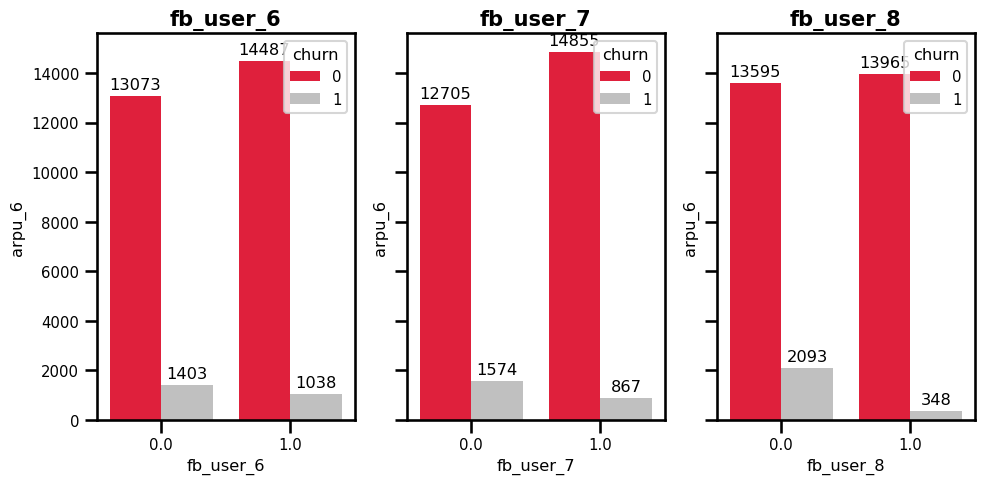

In [37]:
col1 = ['fb_user_6', 'fb_user_7', 'fb_user_8']
dist_bar_plot(telecom, col1, 'arpu_6')

>Significant drop in average revenue in 8th month (churn customers)  for the users who are availing fb_user facility.However ARPU is increasing for churn users who arent avaialing fb_users facility.

In [38]:
# Function to plot columns related to minutes of usage with month
def plotChurnMou(colList, calltype):
    fig, ax = plt.subplots(figsize=(7,4))
    df = telecom.groupby(telecom['churn'])[colList].mean().T
    plt.plot(df[0], linestyle='dashed', marker='o', color='#C0C0C0', label='Non-Churn')
    plt.plot(df[1], linestyle='dashed', marker='o', color='#FF0025', label='Churn')

    months = ['Jun', 'Jul', 'Aug']
    ax.set_xticks(range(len(months)))
    ax.set_xticklabels(months, rotation=0)
    plt.legend(['Non-Churn', 'Churn'])
    plt.title('Avg. '+calltype+' MOU vs Month', loc='left', fontsize=12, fontweight='bold', color='#111111')
    plt.xlabel('Month')
    plt.ylabel('Avg. '+calltype+' MOU')

    for i, txt in enumerate(df[0]):
        ax.annotate(f'{txt:.1f}', (i, df[0][i]), textcoords="offset points", xytext=(0,-10 - (i % 2) * 10), ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'), fontsize=8)

    for i, txt in enumerate(df[1]):
        ax.annotate(f'{txt:.1f}', (i, df[1][i]), textcoords="offset points", xytext=(0,-10 - (i % 2) * 10), ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'), fontsize=8)

In [39]:
# Function to plot columns realted to minures of usage with month
def plotChurn(data, col):
    # per month churn vs Non-Churn
    fig, ax = plt.subplots(figsize=(7,4))
    colList = list(data.filter(regex=(col)).columns)
    colList = colList[:3]
    df1 = telecom.groupby('churn')[colList].mean().T
    plt.plot(df1[0], linestyle='dashed', marker='o', color='#C0C0C0', label='Non-Churn')
    plt.plot(df1[1], linestyle='dashed', marker='o', color='#FF0025', label='Churn')
    
    months = ['Jun', 'Jul', 'Aug']
    ax.set_xticks(range(len(months)))
    ax.set_xticklabels(months, rotation=0)
    plt.legend(['Non-Churn', 'Churn'])
    plt.title(str(col) + ' vs Month', loc='left', fontsize=12, fontweight='bold', color='#111111')
    plt.xlabel('Month')
    plt.ylabel(col)

    for i, txt in enumerate(df1[0]):
        ax.annotate(f'{txt:.0f}', (i, df1[0][i]), textcoords="offset points", xytext=(0,-10 - (i % 2) * 10), ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'), fontsize=8)

    for i, txt in enumerate(df1[1]):
        ax.annotate(f'{txt:.0f}', (i, df1[1][i]), textcoords="offset points", xytext=(0,-10 - (i % 2) * 10), ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'), fontsize=8)

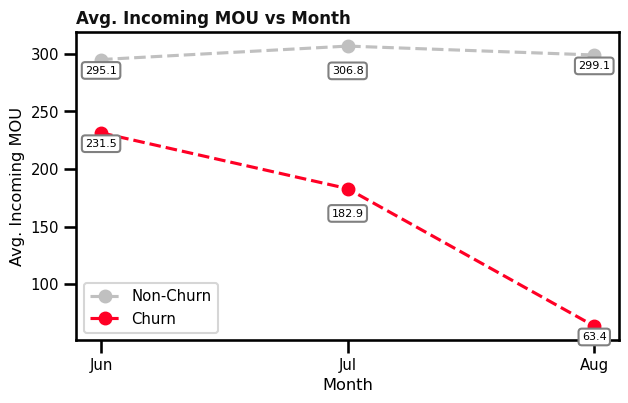

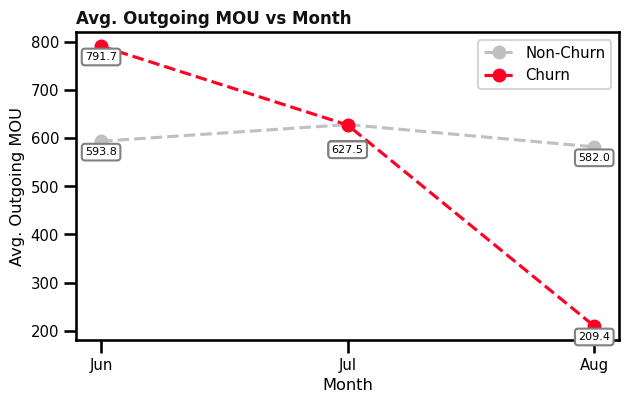

In [40]:
ic_mou = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
og_mou = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plotChurnMou(ic_mou, 'Incoming')
plotChurnMou(og_mou, 'Outgoing')

> Significant drop in total incoming calls and total outgoing calls for churn customers , however for non churn customer its increasing.

### **Data Preparation**
##### Feature Engineering

In [41]:

for i in range(6,9):
    
    """
    Creating derived features: `og_to_ic_mou_6`, `og_to_ic_mou_7`, `og_to_ic_mou_8` These features will hold the ratio (=total_ogmou / total_icmou) for each month.
    These features will combine both incoming and outgoing informations and should be a better predictor of churn.
    """
    # Creating new features which are ratio of total outgoing call with total incoming calls minutes of usage
    telecom['tot_og_to_ic_mou_'+str(i)] = (telecom['total_og_mou_'+str(i)]) / (telecom['total_ic_mou_'+str(i)]+1)
    
    """
    Creating derived features: `loc_og_to_ic_mou_6`, `loc_og_to_ic_mou_7`, `loc_og_to_ic_mou_8` These features will hold the ratio (=loc_ogmou / loc_icmou) for each month.
    These features will combine the local calls, both incoming and outgoing informations and should be a better predictor of churn.
    """
    # Creating new features which are ratio of local outgoing call with local incoming calls minutes of usage
    telecom['loc_og_to_ic_mou_'+str(i)] = (telecom['loc_og_mou_'+str(i)]) / (telecom['loc_ic_mou_'+str(i)]+1)   
    
    """
    Creating derived features: `roam_og_to_ic_mou_6`, `roam_og_to_ic_mou_7`, `roam_og_to_ic_mou_8` These features will hold the ratio (=roam_og_mou / roam_ic_mou) for each month.
    These features will combine the roaming calls, both incoming and outgoing informations and should be a better predictor of churn.
    """
    # Creating new features which are ratio of roaming outgoing call with local incoming calls minutes of usage
    telecom['roam_og_to_ic_mou_'+str(i)] = (telecom['roam_og_mou_'+str(i)]) / (telecom['roam_ic_mou_'+str(i)]+1)
    
    """
    Creating derived features: `spl_og_to_ic_mou_6`, `spl_og_to_ic_mou_7`, `spl_og_to_ic_mou_8` These features will hold the ratio (=spl_og_mou / spl_ic_mou) for each month.
    These features will combine the Special calls, both incoming and outgoing informations and should be a better predictor of churn.
    """
    # Creating new features which are ratio of special outgoing call with local incoming calls minutes of usage
    telecom['spl_og_to_ic_mou_'+str(i)] = (telecom['spl_og_mou_'+str(i)]) / (telecom['spl_ic_mou_'+str(i)]+1)
    
    """
    Creating derived features: std_og_to_ic_mou_6, std_og_to_ic_mou_7, std_og_to_ic_mou_8 These features will hold the ratio (=std_og_mou / std_ic_mou) for each month.
    These features will combine the std calls, both incoming and outgoing informations and should be a better predictor of churn.
    """
    # Creating new features which are ratio of std outgoing call with local incoming calls minutes of usage
    telecom['std_og_to_ic_mou_'+str(i)] = (telecom['std_og_mou_'+str(i)]) / (telecom['std_ic_mou_'+str(i)]+1)
    
    """
    Creating derived features: isd_og_to_ic_mou_6, isd_og_to_ic_mou_7, isd_og_to_ic_mou_8 These features will hold the ratio (=isd_og_mou / isd_ic_mou) for each month.
    These features will combine the isd calls, both incoming and outgoing informations and should be a better predictor of churn.
    """
    # Creating new features which are ratio of isd outgoing call with local incoming calls minutes of usage
    telecom['isd_og_to_ic_mou_'+str(i)] = (telecom['isd_og_mou_'+str(i)]) / (telecom['isd_ic_mou_'+str(i)]+1)
    
    """
    Creating derived features: total_vol_data - Combining vol_2g_mb and vol_3g_mb.
    These features will combine the 2g data usage and 3g data usage and should be a better predictor of churn.
    """
    # Creating new features combining 2G and 3G
    telecom['total_vol_'+str(i)] = (telecom['vol_2g_mb_'+str(i)]) + (telecom['vol_3g_mb_'+str(i)]+1)
    
    """
    Creating derived features: total_arpu - Combining arpu_2g and arpu_3g.
    These features will combine the average revenue per user from 2g and 3g data and should be a better predictor of churn.
    """
    # Creating new features combining average revenue per user from 2g and 3g
    telecom['total_arpu_'+str(i)] = (telecom['arpu_2g_'+str(i)]) + (telecom['arpu_3g_'+str(i)]+1)

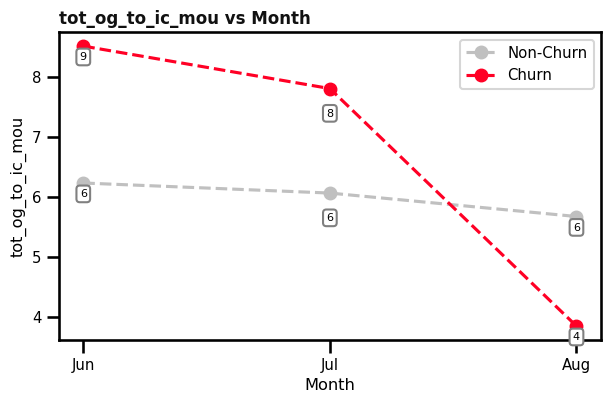

In [42]:
# Display Total Outgoing mou to incoming mou
plotChurn(telecom, 'tot_og_to_ic_mou')

> **Total Outgoing mou to incoming mou**
>> As the ratio of outgoing to incoming seem to be getting dropped for churn customer , we can say incoming calls were less in Jun and singificantly increases which cause the ratio to drop.

In [43]:
plotChurn(telecom, 'loc_og_to_ic_mou')

> Ratio is getting dropped for churn customers

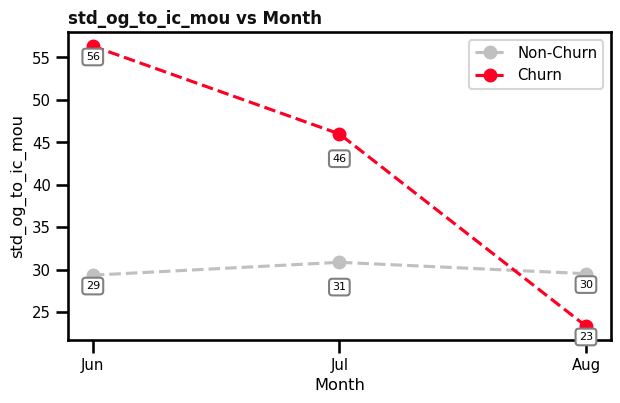

In [44]:
plotChurn(telecom, 'std_og_to_ic_mou')

> **Std outgoing mou to incoming mou**
>> The sharp decline in MOU among churn customers suggests that as they approach the point of churning, their usage decreases significantly. This could indicate dissatisfaction or reduced engagement with the service. The stable MOU for non-churn customers indicates consistent usage patterns, suggesting a steady engagement with the service.

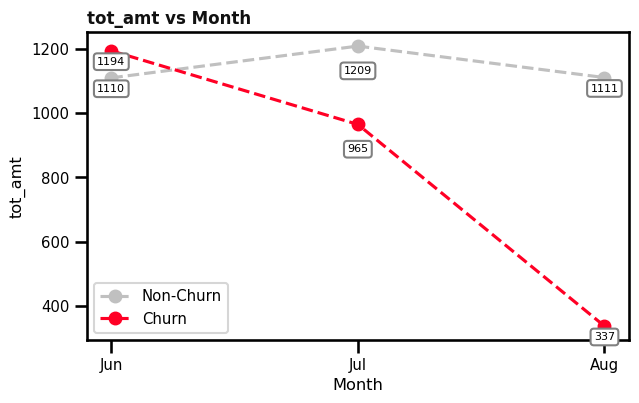

In [45]:
plotChurn(telecom, 'tot_amt')

> Churn customers exhibit a significant decrease in their total amount spent over the three-month period, suggesting a gradual disengagement from the service before ultimately leaving. In contrast, non-churn customers maintain stable spending levels, reflecting consistent and possibly satisfied usage.

In [46]:
plotChurn(telecom, 'total_vol')

> Churn customers exhibit a marked decrease in total volume from June to August, suggesting a gradual disengagement from the service. In contrast, non-churn customers maintain a stable total volume, indicating continuous and consistent usage.

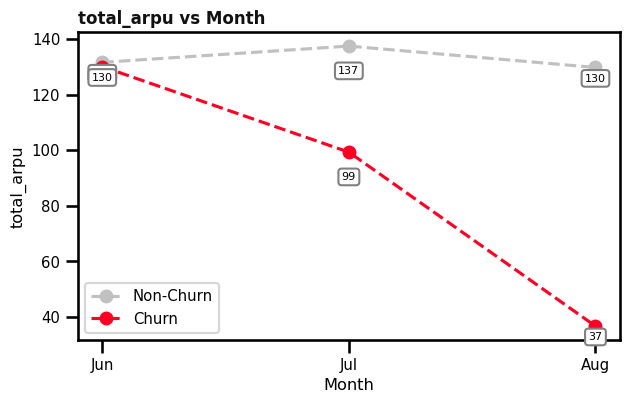

In [47]:
plotChurn(telecom, 'total_arpu')

In [48]:
date_cols = ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',\
            'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

# Convert columns to datetime using the correct format
for col in date_cols:
    telecom[col] = pd.to_datetime(telecom[col], format='%m/%d/%Y', errors='coerce')

# Extract the day of the week
for i in range(6,9):
    telecom['date_of_last_rech_dow_'+str(i)] = telecom['date_of_last_rech_'+str(i)].dt.dayofweek.astype(str)
    telecom['date_of_last_rech_data_dow_'+str(i)] = telecom['date_of_last_rech_data_'+str(i)].dt.dayofweek.fillna(7).astype(int).astype(str)
# telecom['date_of_last_rech_dow_6'] = telecom['date_of_last_rech_6'].dt.dayofweek.astype(str)
# telecom['date_of_last_rech_dow_7'] = telecom['date_of_last_rech_7'].dt.dayofweek.astype(str)
# telecom['date_of_last_rech_dow_8'] = telecom['date_of_last_rech_8'].dt.dayofweek.astype(str)
# telecom['date_of_last_rech_data_dow_6'] = telecom['date_of_last_rech_data_6'].dt.dayofweek.fillna(7).astype(int).astype(str)
# telecom['date_of_last_rech_data_dow_7'] = telecom['date_of_last_rech_data_7'].dt.dayofweek.fillna(7).astype(int).astype(str)
# telecom['date_of_last_rech_data_dow_8'] = telecom['date_of_last_rech_data_8'].dt.dayofweek.fillna(7).astype(int).astype(str)

In [49]:
# Recent recharge date
cols = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
telecom['last_rech_date'] = telecom[cols].max(axis=1)

# Number of days from the recent charge date till the last date of Aug/8th month
telecom['days_since_last_rech'] = (pd.to_datetime('2014-08-31', format='%Y-%m-%d') - telecom['last_rech_date']).dt.days

# Subtract it from 3 to add higher weightage for values present in all the columns
# len(cols) = 3, means present in all columns, 0 means not present in any column
telecom['rech_weightage'] = len(cols) - (telecom[cols].isnull().sum(axis=1))
telecom.drop(['last_rech_date', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis=1, inplace=True)

# Recent recharge data date
cols = ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']
telecom['last_rech_data_date'] = telecom[cols].max(axis=1)

# Number of days from the recent recharge data date till the last date of Aug/8th month
telecom['days_since_last_data_rech'] = (pd.to_datetime('2014-08-31', format='%Y-%m-%d') - telecom['last_rech_data_date']).dt.days
telecom['days_since_last_data_rech'] = telecom['days_since_last_data_rech'].fillna(0)

# Subtract it from 3 to add higher weightage for values present in all the columns
# len(cols) = 3, means present in all columns, 0 means not present in any column
telecom['rech_data_weightage'] = len(cols) - (telecom[cols].isnull().sum(axis=1))
telecom.drop(['last_rech_data_date', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis=1, inplace=True)

# Verify the results
telecom.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0    197.385   214.816   213.803        0.402         0.00         0.00   
7   1069.180  1349.850  3171.480       57.840        54.68        52.29   
8    378.721   492.223   137.362      413.690       351.03        35.08   
21   514.453   597.753   637.760      102.410       132.11        85.14   
23    74.350   193.897   366.966       48.960        50.66        33.58   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0          2.176          2.21          0.00           0.00           0.00   
7        453.430        567.16        325.91          16.23          33.49   
8         94.660         80.63        136.48           0.00           0.00   
21       757.930        896.68        983.39           0.00           0.00   
23        85.410         89.36        205.89           0.00           0.00   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.00           0.00           0.00           0.00   
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              0.402              0.00              0.00             1.098   
7             51.390             31.38             40.28           308.630   
8            297.130            217.59             12.49            80.960   
21             4.480              6.16             23.34            91.810   
23            48.960             50.66             33.58            82.940   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0              0.106              0.00              0.00              0.07   
7            447.380            162.28             62.13             55.14   
8             70.580             50.54              0.00              0.00   
21            87.930            104.81              0.75              0.00   
23            83.010            148.56              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0               0.00             1.078             0.566              0.00   
7              53.23             0.000             0.000              0.00   
8               0.00             0.000             0.000              7.15   
21              1.58             0.000             0.000              0.00   
23              0.00             0.000             0.000             17.71   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0           1.50         0.176          0.00              0.00   
7         422.16       533.910        255.79              4.30   
8         378.09       288.180         63.04            116.56   
21         97.04        94.090        129.74             97.93   
23        131.91       133.680        182.14              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0               0.00              0.00              0.00              0.00   
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.00              0.00              0.00              0.00   
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23             39.61      

In [50]:
cat1 =['night_pck_user_6','monthly_2g_6','sachet_2g_6','monthly_3g_6','sachet_3g_6','fb_user_6',\
       'night_pck_user_7','monthly_2g_7','sachet_2g_7','monthly_3g_7','sachet_3g_7','fb_user_7',\
       'date_of_last_rech_dow_6','date_of_last_rech_dow_7','date_of_last_rech_data_dow_6','date_of_last_rech_data_dow_7',\
       'date_of_last_rech_dow_8','date_of_last_rech_data_dow_8','night_pck_user_8','monthly_2g_8','sachet_2g_8',\
       'monthly_3g_8','sachet_3g_8','fb_user_8']
cat2 =['night_pck_user_6','fb_user_6','night_pck_user_7','fb_user_7',\
       'date_of_last_rech_dow_6','date_of_last_rech_dow_7','date_of_last_rech_data_dow_6','date_of_last_rech_data_dow_7',\
       'date_of_last_rech_dow_8','date_of_last_rech_data_dow_8','night_pck_user_8','monthly_2g_8','sachet_2g_8',\
       'monthly_3g_8','sachet_3g_8','fb_user_8']
num_col = list(set(telecom.columns).difference(set(cat1)))
num_col

['isd_og_mou_7',
 'loc_ic_mou_8',
 'total_rech_num_7',
 'loc_ic_t2t_mou_6',
 'count_rech_2g_7',
 'rech_weightage',
 'total_rech_amt_6',
 'isd_ic_mou_7',
 'std_ic_t2t_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_to_ic_mou_6',
 'total_og_mou_8',
 'loc_og_to_ic_mou_7',
 'arpu_3g_6',
 'av_rech_amt_data_7',
 'total_arpu_6',
 'isd_og_mou_8',
 'loc_ic_t2m_mou_8',
 'std_og_t2f_mou_8',
 'loc_og_to_ic_mou_8',
 'loc_ic_t2m_mou_7',
 'std_ic_t2t_mou_7',
 'max_rech_data_6',
 'std_ic_t2f_mou_6',
 'std_og_t2f_mou_7',
 'loc_og_mou_8',
 'arpu_8',
 'offnet_mou_8',
 'isd_ic_mou_8',
 'onnet_mou_6',
 'roam_og_to_ic_mou_6',
 'total_vol_6',
 'std_og_mou_7',
 'churn',
 'std_ic_t2m_mou_8',
 'arpu_7',
 'std_og_t2m_mou_6',
 'loc_og_mou_6',
 'roam_og_mou_8',
 'std_og_t2t_mou_6',
 'total_vol_8',
 'vol_3g_mb_8',
 'spl_og_to_ic_mou_6',
 'std_og_mou_6',
 'spl_og_mou_7',
 'loc_ic_mou_6',
 'tot_og_to_ic_mou_7',
 'loc_og_t2f_mou_8',
 'std_ic_t2m_mou_7',
 'total_rech_data_6',
 'loc_og_t2t_mou_6',
 'max_rech_amt_8',
 'count_rech_

Creating new features which will be average of all columns for 6th and 7th

In [51]:
# Filtering columns name by removing only last character of column name
col_list = telecom.select_dtypes(include=['float64', 'int64']).filter(regex='_6|_7').drop(cat1[:12], axis=1).drop(['avg_amt_6_7', 'og_others_6'], axis=1).columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    col_name = 'avg67_'+col # Crete the column name dynamically
    col6 = col+'_6'
    col7 = col+'_7'
    telecom[col_name] = round((telecom[col6] + telecom[col7]) / 2, 2)
telecom[col_name]

0        425.34
7          1.00
8          1.00
21         1.00
23       305.17
          ...  
99981    425.35
99984      5.22
99986      1.45
99988      1.00
99997    538.02
Name: avg67_total_arpu, Length: 30001, dtype: float64

In [52]:
# Deriving columns difference between 8 month column and avg of 6th and 7th column calculated above
col_list1 = telecom.select_dtypes(include=['float64', 'int64']).filter(regex='avg67_').columns
col_list2 = telecom.select_dtypes(include=['float64', 'int64']).filter(regex='_8').drop(['fb_user_8', 'night_pck_user_8'], axis=1).columns
for col1, col2 in zip(col_list1, col_list2):
    col_name = col2[:-2]+'avgdiff8'
    telecom[col_name] = telecom[col2] - telecom[col1]

In [53]:
# Dropping those cols since we already created features from it (dropping because of multicollinearity)
col_list = telecom.select_dtypes(include=['float64', 'int64']).filter(regex='_6|_7').drop(cat1[:12], axis=1).drop(['avg_amt_6_7', 'og_others_6'], axis=1).columns
telecom.drop(col_list, axis=1, inplace=True)
num_col = list(set(telecom.columns).difference(set(cat1)))

In [54]:
dummy_df = pd.get_dummies(telecom[cat1], drop_first=True)
telecom = pd.concat([telecom, dummy_df], axis=1)
telecom = telecom.drop(cat1, axis=1)

##### **Handling Skewness**

In [55]:
# Let's find out if numerical predictor variables are largely skewness or not
tel_num = telecom[num_col]
skew_feat = tel_num.apply(lambda x: skew(list(x))).sort_values(ascending=False)
high_skew = skew_feat[skew_feat > 0.5]
skew_index = high_skew.index
skewness = pd.DataFrame({'Skew':high_skew})
pd.DataFrame(skew_feat, columns=['Skewness']).head(10)

Skewness
roam_og_to_ic_mou_8      168.378029
avg67_isd_og_to_ic_mou   153.210816
isd_og_to_ic_mou_8       148.243237
og_others_6              110.070817
avg67_roam_og_to_ic_mou  108.020078
avg67_isd_og_mou          88.242880
isd_og_mou_8              88.041259
avg67_spl_ic_mou          58.158573
avg67_ic_others           55.167106
loc_og_to_ic_mou_8        54.529646

> As we can see from skewness values, predictor variables are highly skewed. We need to take care of skewness.

In [56]:
# Removing Skewness
num_col.remove('churn')
qtl_transfm = QuantileTransformer()
telecom[num_col] = qtl_transfm.fit_transform(telecom[num_col])

##### **Handling Imbalance Dataset**
There are many techniques available. I am using ADASYN(Adaptive Synthetic) which is an improved version of SMOTE.
What it does is same as SMOTE just with a minor improvement. After creating those sample it adds a random small values to the points thus making it more realistic. In other words instead of all the sample being linearly correlated to the parent they have a little more variance in them i.e they are bit scattered.

In [57]:
X = telecom.drop('churn', axis=1) # Independent/predictor variable
y = telecom['churn'] # Output variables

In [58]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(24000, 205)
(6001, 205)


There are many techniques available. I am using SMOTE

In [59]:
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

In [60]:
# ads = ADASYN()
# X_train, y_train = ads.fit_resample(X_train, y_train)

Scaling

In [61]:
# Scaling using StandardScaler scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

Applying PCA

In [62]:
pca = PCA(0.9)
df_train = pca.fit_transform(X_train)
df_train.shape

(44050, 75)

In [63]:
df_train

array([[ 9.52934547,  1.36409485, -1.91156323, ...,  0.96575188,
        -0.61416262,  0.16923675],
       [-4.71886255, -1.26029396, -2.94336846, ..., -0.53220873,
        -1.34789161,  0.03398668],
       [-1.29538785,  4.17751625, -2.68612637, ..., -0.77101024,
        -0.53074542, -1.41036817],
       ...,
       [-4.63525792,  4.39912814,  0.33350054, ...,  0.87513087,
         0.71429589,  0.39710718],
       [-7.46652253, -3.30268464, -0.90644139, ..., -0.68930699,
         0.61977757,  0.67792096],
       [-0.87494366,  4.6796734 , -4.2107893 , ...,  0.0841533 ,
         1.14345996, -0.28948011]])

<Axes: >

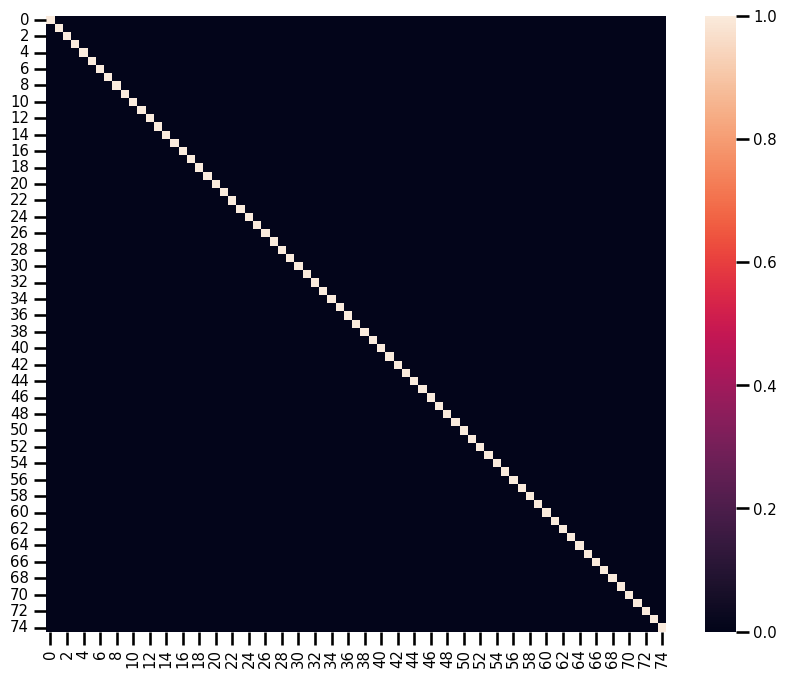

In [64]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(df_train).corr())

> All principal components are correlated with each other

In [65]:
# Initializing PCA with n_components=61
pca = PCA(n_components=70, random_state=42, svd_solver='randomized')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [66]:
# Transforming X also using PCA, since we still use it during cross valdation
pca = PCA(n_components=70, random_state=42, svd_solver='randomized')
X_pca = pca.fit_transform(X)

In [67]:
# Function to plot accuracy metrics
def model_metrics(actual, predicted):
    confusion = confusion_matrix(actual, predicted)
    TP = confusion[1,1] # True Positives
    TN = confusion[0,0] # True Negatives
    FP = confusion[0,1] # False Positives
    FN = confusion[1,0] # False Negatives
    acc_score = round(accuracy_score(actual, predicted), 2) # Accuracy Score
    rcl_score = round(recall_score(actual,predicted), 2) # Recall Score
    roc_score = round(roc_auc_score(actual, predicted), 2) # rock_auc_score
    fpr = round(FP / float(TN+FP), 2) # False Positive Rate
    specificity = round(TN / float(TN + FP), 2) # Specificity
    metrics_df = pd.DataFrame(data=[[acc_score, roc_score, fpr, specificity, rcl_score, TP, TN, FP, FN]],
                              columns=['accuracy', 'roc_auc', 'fpr', 'specificity', 'recall_score', 'true_positive', 'true_negative', 'false_positive', 'false_negative'], index=['score'])
    return metrics_df    

### **Data Modelling**

In [68]:
# Function to predict class labels based on mode predicted probability and cutoff/threshold for assigning labels
def predChurnLabelonCutOff(model, X, y, threshold=.5):
    pred_probs = model.predict_proba(X)[:,1]
    pred_df = pd.DataFrame({'churn':y, 'churn_Prob':pred_probs})
    # Creating new column 'predicted' with 1 if Churn_Prob > threshold else 0
    pred_df['predicted'] = pred_df['churn_Prob'].map(lambda x: 1 if x > threshold else 0)
    return pred_df

In [69]:
def optimal_cutoff(df):
    # Create columns with different probabilty cutoffs
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i] = df['churn_Prob'].map(lambda x: 1 if x > i else 0)
    
    # Calculate accuracy sensivity and specificity for various probability cutoffs
    cutoff_df = pd.DataFrame(columns=['prob', 'accuracy', 'recall', 'specificity'])
    num = [0.0 , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for i in num:
        cm1 = confusion_matrix(df['churn'], df[i])
        total1 = sum(sum(cm1))
        accuracy = (cm1[0,0] + cm1[1,1]) / total1
        speci = cm1[0,0] / (cm1[0,0] + cm1[0,1]) if (cm1[0,0] + cm1[0,1]) != 0 else 0
        sensi = cm1[1,1] / (cm1[1,0] + cm1[1,1]) if (cm1[1,0] + cm1[1,1]) != 0 else 0
        new_row = pd.DataFrame({'prob': [i], 'accuracy': [accuracy], 'recall': [sensi], 'specificity': [speci]})
        cutoff_df = pd.concat([cutoff_df, new_row], ignore_index=True)

    cutoff_df.plot.line(x='prob', y=['accuracy', 'recall', 'specificity'], figsize=(8,6))
    plt.show()

> We want to predict customers who are likely to churn(positive class). Hence, we want to maximize(Recall/Senstivity). Also, we don't want to drop accuracy or roc_auc value much while maximising recall

##### BaseLine Models (Without tuning hyperparameters, running with default parameters)

### **Naive Bayes Classifier**

In [70]:
gnb = GaussianNB()
gnb.fit(X_train_pca, y_train)
y_test_pred = gnb.predict(X_test_pca)
print('Classification Report:\n')
print(classification_report(y_test, y_test_pred))
print('Confussion Matrix:\n')
print(confusion_matrix(y_test, y_test_pred))
model_metrics(y_test, y_test_pred)

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      5535
           1       0.23      0.76      0.35       466

    accuracy                           0.78      6001
   macro avg       0.60      0.77      0.61      6001
weighted avg       0.92      0.78      0.83      6001

Confussion Matrix:

[[4352 1183]
 [ 114  352]]


accuracy  roc_auc   fpr  specificity  recall_score  true_positive  \
score      0.78     0.77  0.21         0.79          0.76            352   

       true_negative  false_positive  false_negative  
score           4352            1183             114

### **Logistic Regression (Default Parameters)**

In [71]:
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_pca, y_train) # Fitting model
y_test_pred = log_reg.predict(X_test_pca) # Model Prediction
print(classification_report(y_test, y_test_pred))
model_metrics(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5535
           1       0.35      0.82      0.49       466

    accuracy                           0.87      6001
   macro avg       0.67      0.85      0.71      6001
weighted avg       0.93      0.87      0.89      6001



accuracy  roc_auc   fpr  specificity  recall_score  true_positive  \
score      0.87     0.85  0.13         0.87          0.82            382   

       true_negative  false_positive  false_negative  
score           4834             701              84

### **Logistic Regression (Tuned Hyperparameters)**

In [72]:
# Stratified KFold for cross Validation
fold = StratifiedKFold(random_state=42, shuffle=True, n_splits=5)

params = {'penalty':['l1'],
          'C':list(np.power(10.0, np.arange(-2, 3))),
          'solver':('saga', 'liblinear'),
          'class_weight':['balanced']}

# Using scoring metrics recall
log_regcv = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid=params, cv=fold, scoring='recall', verbose=1, return_train_score=True)
log_regcv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'class_weight': ['balanced'], 'penalty': ['l1'],
                         'solver': ('saga', 'liblinear')},
             return_train_score=True, scoring='recall', verbose=1)

In [73]:
print(log_regcv.best_params_)
print(log_regcv.best_score_)
print(log_regcv.best_estimator_)
log_regcv = log_regcv.best_estimator_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
0.8843132803632237
LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')


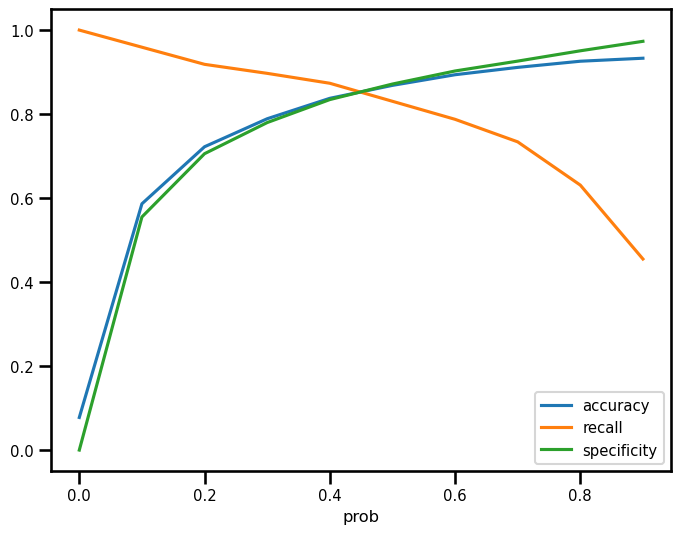

In [74]:
log_regcv.fit(X_train_pca, y_train) #Fitting best models
df_cutoff = predChurnLabelonCutOff(log_regcv, X_test_pca, y_test)
optimal_cutoff(df_cutoff)

### Key Insights:

**Trade-off between Recall and Specificity:**
 - There is a trade-off between recall and specificity. As the threshold increases, recall decreases while specificity increases. This means the model gets better at avoiding false positives, but could miss some true positives.

**Optimal Threshold:**
 - Choose the optimal threshold depending on business needs. If the primary goal is to identify as many customers as possible who will churn (minimize churn), you may want to use a lower threshold to ensure high recall. However, if the cost of false positives is high, you may want to use a higher threshold to increase specificity.

**Stable Accuracy:**
 - Model accuracy tends to stabilize after a certain threshold (around 0.5). This shows that the model has a good balance between recall and specificity around this threshold.

In [75]:
threshold = .25 #From the above graph (recall, accuracy and specificity have good score)
y_test_pred = predChurnLabelonCutOff(log_regcv, X_test_pca, y_test, threshold)
y_test_pred.predicted
print('Classification Report:\n')
print(classification_report(y_test, y_test_pred['predicted']))
print('Confusion Matrix:\n')
print(confusion_matrix(y_test, y_test_pred['predicted']))
model_metrics(y_test, y_test_pred['predicted'])

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      5535
           1       0.23      0.91      0.37       466

    accuracy                           0.76      6001
   macro avg       0.61      0.83      0.61      6001
weighted avg       0.93      0.76      0.81      6001

Confusion Matrix:

[[4125 1410]
 [  41  425]]


accuracy  roc_auc   fpr  specificity  recall_score  true_positive  \
score      0.76     0.83  0.25         0.75          0.91            425   

       true_negative  false_positive  false_negative  
score           4125            1410              41

### **KNN (Default Hyperparameters)**

In [76]:
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)
y_test_pred = knn.predict(X_test_pca)
print('Classification Report:\n')
print(classification_report(y_test, y_test_pred))
print('Confusion Matrix:\n')
print(confusion_matrix(y_test, y_test_pred))
model_metrics(y_test, y_test_pred)

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5535
           1       0.32      0.74      0.45       466

    accuracy                           0.86      6001
   macro avg       0.65      0.80      0.68      6001
weighted avg       0.92      0.86      0.88      6001

Confusion Matrix:

[[4801  734]
 [ 121  345]]


accuracy  roc_auc   fpr  specificity  recall_score  true_positive  \
score      0.86      0.8  0.13         0.87          0.74            345   

       true_negative  false_positive  false_negative  
score           4801             734             121

### **KNN (Tuned Hyperparameters)**

In [77]:
fold = StratifiedKFold(random_state=42, shuffle=True, n_splits=3) #Stratified KFold for cross validation
# params = {'n_neighbors':list(range(1,6)), 'p':[1,2], 'weights':['uniform', 'distance']}
# Setting params to tuned values, since it takes around 3hrs for 30 fits with knn
# Ran gridsearchcv on above paramgerids with 30 fits and found these tuned params
params = {'n_neighbors':[3], 'p':[2]}
# Using scoring metrics recall
knn_cv = GridSearchCV(knn, param_grid=params, cv=fold, scoring='recall', verbose=1, return_train_score=True)
knn_cv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3], 'p': [2]}, return_train_score=True,
             scoring='recall', verbose=1)

In [78]:
print(knn_cv.best_params_)
print(knn_cv.best_score_)
print(knn_cv.best_estimator_)
# Test set prediction using tuned model
knn_cv = knn_cv.best_estimator_ # best parameters value for knn

{'n_neighbors': 3, 'p': 2}
0.9999091858511556
KNeighborsClassifier(n_neighbors=3)


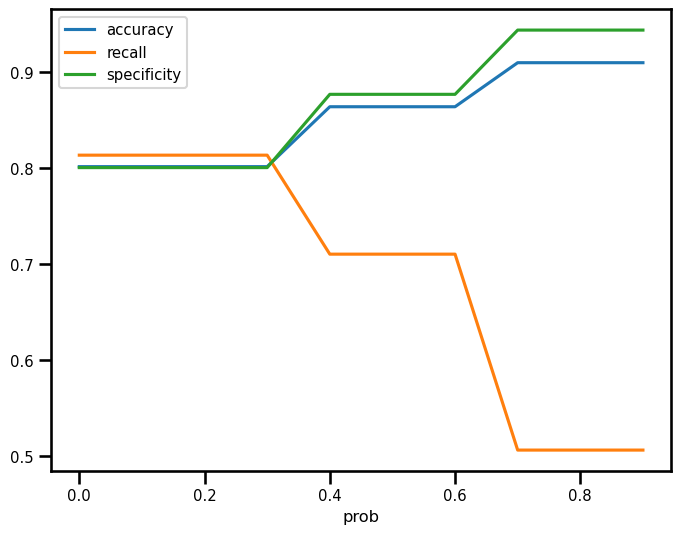

In [79]:
knn_cv.fit(X_train_pca, y_train)
df_cutoff = predChurnLabelonCutOff(knn_cv, X_test_pca, y_test)
optimal_cutoff(df_cutoff)